# 원티드 국민연금 DB를 이용해서 유니콘 기업 발굴하기

# 주요 내용 및 순서
### 1. DB구조 파악 및 Column별 검토
### 2. 분석에 필요한 Column 추가 및 데이터 전처리
### 3. 주요 지표 설정 및 지표별 분석
- **유니콘 기업 선정을 위한 주요 지표 설정**
  * 지표1. 연매출액 => 세부적으로 3개의 지표 산출
      - 세부지표 1) 연평균성장률(CAGR)
      - 세부지표 2) 3개년 지속성장 여부
      - 세부지표 3) 3개년 매출평균
  * 지표2. 월별_직원수
  * 지표3. 인당_연금보험료(평균)
<br/><br/>
- **지표별 실적에 따른 차등 점수 부여 및 후보 리스트 추출**
  * 지표1. 연매출액<br/>
      : 세부적으로 추출한 3개 지표별 결과값에 따른 점수 차등 부여 및 상위 20개 후보 선정
  * 지표2. 월별_직원수<br/>
      : 지표 분석 및 기준 설정 후, 특정 기준에 못 미치는 후보 제외
  * 지표3. 인당_연금보험료(평균)<br/>
      : 지표 분석 및 기준 설정 후, 특정 기준에 못 미치는 후보 제외

### 4. 유니콘 기업 최종 선정
- (첨부) 최종 유니콘 선정 회사ID별 그래프 추이 확인

# 1. DB구조 파악 및 Column별 검토

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
# matplotlib 한글 깨짐 현상 관련 처리
plt.rcParams["font.family"]="Malgun Gothic"
plt.rcParams["axes.unicode_minus"]=False

In [151]:
file_path = "./data/company_nps_data.csv"

df = pd.read_csv(file_path, encoding="cp949")  # 한글 관련 오류로 인코딩 설정
df

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151
...,...,...,...,...,...,...
99796,171439,4630622,2017,2,2402740,11
99797,239388,1045021,2018,10,1428800,9
99798,272304,181898,2018,3,392560,4
99799,362194,2100218,2018,12,874780,3


In [152]:
df.shape

(99801, 6)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   회사ID      99801 non-null  int64
 1   연매출액      99801 non-null  int64
 2   년도        99801 non-null  int64
 3   월         99801 non-null  int64
 4   월별_연금보험료  99801 non-null  int64
 5   월별_직원수    99801 non-null  int64
dtypes: int64(6)
memory usage: 4.6 MB


### Column별 검토

### 1) 회사ID

    => 회사에 부여된 고유한 ID값으로, 숫자의 크고 작음은 크게 의미없는 것으로 판단됨

In [154]:
회사ID_list = df.회사ID.unique()
print(회사ID_list)
len(회사ID_list)  # 회사ID 고유한 값 개수 확인 => 5000개 회사

[233757 123464 342124 ... 547774 413938  96128]


5000

In [155]:
회사ID_list = np.sort(회사ID_list)  # 오름차순 정렬
회사ID_list

array([     63,      95,     102, ..., 2693684, 3312354, 5159723],
      dtype=int64)

In [156]:
회사ID_list[:50]  # 회사ID 초반 내역 확인

array([   63,    95,   102,   295,   414,   597,   786,   917,  1052,
        1125,  1715,  1807,  2031,  2037,  2360,  2483,  2745,  2807,
        2842,  2993,  3611,  3828,  4234,  4534,  4926,  5202,  5452,
        5711,  6184,  6438,  7046,  7153,  8208,  8268,  8496,  8835,
        9061,  9613,  9734,  9862, 10348, 10564, 10881, 10929, 11393,
       12022, 12272, 12767, 13481, 13827], dtype=int64)

In [157]:
회사ID_list[4950:]  # 회사ID 후반 내역 확인

array([ 586026,  589218,  589964,  590442,  590500,  590763,  591540,
        594485,  596878,  596960,  597632,  597726,  598218,  599171,
        602137,  604914,  613233,  613313,  613430,  613668,  615532,
        615554,  617524,  617791,  620445,  630190,  635082,  691111,
        742694,  756518,  782086,  789269,  794223,  839180,  851154,
        900163,  918661,  933076,  990805, 1021039, 1065828, 1949405,
       1983879, 2256869, 2329349, 2400284, 2437574, 2693684, 3312354,
       5159723], dtype=int64)

### 2) 연매출액
* 연단위 data로, 해당연도 월별 동일한 금액 입력된 것 확인

    => 회사ID 기준 그룹핑 후 추가 검토 진행 예정

In [158]:
r = df.sort_values("회사ID")
r.head(20)  # 동일한 회사의 연매출액 입력방식 파악 => 해당연도 월별 동일한 금액 입력됨

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
79358,63,11328779396,2018,9,416186660,999
74251,63,11328779396,2018,2,406770960,1018
23302,63,11328779396,2018,7,418169080,1009
80947,63,11328779396,2018,3,404826240,1013
98243,63,11328779396,2018,11,414081820,995
33039,63,11328779396,2018,1,403119840,1006
6449,63,11328779396,2018,6,401083100,1011
80770,63,11328779396,2018,4,404211800,1012
52606,63,11328779396,2018,8,418292620,1011
53569,63,11328779396,2018,12,419953960,1014


### 3) 년도
* 전체 data상 연도 범위 확인 완료 => 2015년 ~ 2019년

In [159]:
df.년도.unique()  # data상 연도 범위 확인

array([2018, 2015, 2016, 2017, 2019], dtype=int64)

### 4) 월
* 전체 data상 월단위 범위 확인 완료 => 2015년 11월 ~ 2019년 12월

In [160]:
# 연도별 월단위 범위 확인
for key, value in df.groupby("년도")["월"]:
    value = value.unique()  # 중복값 제외
    value = np.sort(value)  # 오름차순 정렬
    print(key, value)

2015 [11 12]
2016 [ 1  2  3  4  5  6  7  8  9 10 11 12]
2017 [ 1  2  3  4  5  6  7  8  9 10 11 12]
2018 [ 1  2  3  4  5  6  7  8  9 10 11 12]
2019 [ 1  2  3  4  5  6  7  8  9 10 11 12]


### 5) 월별_연금보험료
* 연금보험료 관련 개념
 - 총액 = 기준소득월액 * 9%(연금보험률)
 - 기준소득월액은 최저 33만원에서 최고 524만원까지의 범위로 결정됨(2021.7.1 ~ 2022.6.30 기준)
 - 참조 사이트
     * https://www.nps.or.kr/jsppage/business/insure_cal.jsp - 총액 산출기준
     * https://www.npsonair.kr/basic3/2223 - 기준소득월액 기준
 
  => 회사별로 직원 급여 수준에 따라 정해지는 금액으로, 회사ID 기준 그룹핑 후 추가 검토 예정

### 6) 월별_직원수
* 회사별 해당월의 직원수 정보로, 회사ID 기준 그룹핑 후 추가 검토 예정

### Column별 검토 결과
1) 회사별 직원 평균급여의 상대적 추이를 확인할 수 있는 지표로 "인당_연금보험료(평균)"를 추가해 활용하고자 함
 - 산출 방법 : "월별_연금보험료" / "월별_직원수"
 - 데이터프레임상 "인당_연금보험료(평균)" 신규 Column 추가

2) 주요 지표에 대한 각 회사별 추이를 다각도로 분석 예정
 - 주요 지표(안) : "연매출액", "월별_직원수", "인당_연금보험료(평균)"

# 2. 분석에 필요한 Column 추가 및 데이터 전처리

### 신규 Column 추가 : "인당_연금보험료(평균)"

In [161]:
# 세부내역 확인 과정에서 데이터프레임 값 출력 시, 과학적표기법(Scientific notation)으로 출력되는 경우가 있어 셋팅 변경
pd.set_option("display.float_format", "{:.1f}".format)  # 항상 float 형식으로 출력되도록 설정

In [162]:
# 계산 및 Colomn 추가 후 확인
df_v2 = df
df_v2["인당_연금보험료(평균)"] = df_v2["월별_연금보험료"] / df_v2["월별_직원수"]
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   회사ID          99801 non-null  int64  
 1   연매출액          99801 non-null  int64  
 2   년도            99801 non-null  int64  
 3   월             99801 non-null  int64  
 4   월별_연금보험료      99801 non-null  int64  
 5   월별_직원수        99801 non-null  int64  
 6   인당_연금보험료(평균)  99788 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 5.3 MB


In [163]:
# "인당_연금보험료(평균)"이 NaN인 경우 0으로 대체 후 int로 형변환
for i, v in enumerate(df_v2["인당_연금보험료(평균)"].isna()):
    if v == True:
        df_v2.loc[i, "인당_연금보험료(평균)"] = 0
        #print(df_v2.loc[i])

df_v2["인당_연금보험료(평균)"] = df_v2["인당_연금보험료(평균)"].apply(lambda x : int(x))
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   회사ID          99801 non-null  int64
 1   연매출액          99801 non-null  int64
 2   년도            99801 non-null  int64
 3   월             99801 non-null  int64
 4   월별_연금보험료      99801 non-null  int64
 5   월별_직원수        99801 non-null  int64
 6   인당_연금보험료(평균)  99801 non-null  int64
dtypes: int64(7)
memory usage: 5.3 MB


In [164]:
df_v2.head(10)

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균)
0,233757,41688077,2018,7,8912380,36,247566
1,123464,1760695,2018,3,942380,5,188476
2,342124,3221341,2018,7,781180,4,195295
3,386420,4815584,2015,11,3795900,14,271135
4,129243,9799736,2018,10,40724680,151,269699
5,508810,239047,2018,3,528980,5,105796
6,365169,3650711,2016,4,570320,3,190106
7,189562,7119908,2016,1,1276900,6,212816
8,133518,18642904,2018,10,16844840,75,224597
9,190847,2367117,2015,12,2354660,8,294332


### 효과적인 분석을 위해 필요한 정보 Column 추가 및 보완 작업 : 날짜 정보 data

In [165]:
# 날짜 정보를 다루기 위해 "연월일" Column 별도로 생성 : '일(day)'은 임의로 1로 설정
df_v2["연월일"] = df_v2["년도"].astype("str") + "/" + df_v2["월"].astype("str") + "/1"
df_v2["연월일"] = pd.to_datetime(df_v2["연월일"])
df_v2.head(10)

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균),연월일
0,233757,41688077,2018,7,8912380,36,247566,2018-07-01
1,123464,1760695,2018,3,942380,5,188476,2018-03-01
2,342124,3221341,2018,7,781180,4,195295,2018-07-01
3,386420,4815584,2015,11,3795900,14,271135,2015-11-01
4,129243,9799736,2018,10,40724680,151,269699,2018-10-01
5,508810,239047,2018,3,528980,5,105796,2018-03-01
6,365169,3650711,2016,4,570320,3,190106,2016-04-01
7,189562,7119908,2016,1,1276900,6,212816,2016-01-01
8,133518,18642904,2018,10,16844840,75,224597,2018-10-01
9,190847,2367117,2015,12,2354660,8,294332,2015-12-01


In [166]:
df_v2.info()  # type 등 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   회사ID          99801 non-null  int64         
 1   연매출액          99801 non-null  int64         
 2   년도            99801 non-null  int64         
 3   월             99801 non-null  int64         
 4   월별_연금보험료      99801 non-null  int64         
 5   월별_직원수        99801 non-null  int64         
 6   인당_연금보험료(평균)  99801 non-null  int64         
 7   연월일           99801 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(7)
memory usage: 6.1 MB


In [167]:
# 회사별로 data의 시작시점과 종료시점 정보 추가 입력 => (참고)아래 반복문 실행 완료까지 약 5분의 시간이 걸림
df_v2["Start_date"] = 0  # "Start_date" Column 생성 및 초기화
df_v2["End_date"] = 0  # "End_date" Column 생성 및 초기화

df_info = pd.DataFrame(columns=["Start_date", "End_date"])  # 추후 활용을 위해 별도 데이터프레임 선언

for k, v in df_v2.groupby("회사ID"):
    min_date = v["연월일"].min()  # 시작시점 정보 저장
    max_date = v["연월일"].max()  # 종료시점 정보 저장
    df_info.loc[k] = [min_date, max_date]  # 추후 활용을 위해 선언한 별도 데이터프레임에 내용 저장
    for i in df_v2[df_v2["회사ID"] == k].index:  # 해당 회사ID의 인덱스 기준으로 시작시점, 종료시점 정보 입력
        df_v2.loc[i, "Start_date"] = min_date
        df_v2.loc[i, "End_date"] = max_date

In [168]:
# datetime type 변환
df_v2["Start_date"] = pd.to_datetime(df_v2["Start_date"])
df_v2["End_date"] = pd.to_datetime(df_v2["End_date"])
df_v2.head(10)

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균),연월일,Start_date,End_date
0,233757,41688077,2018,7,8912380,36,247566,2018-07-01,2015-11-01,2018-12-01
1,123464,1760695,2018,3,942380,5,188476,2018-03-01,2016-01-01,2018-12-01
2,342124,3221341,2018,7,781180,4,195295,2018-07-01,2016-04-01,2018-12-01
3,386420,4815584,2015,11,3795900,14,271135,2015-11-01,2015-11-01,2018-12-01
4,129243,9799736,2018,10,40724680,151,269699,2018-10-01,2015-11-01,2018-12-01
5,508810,239047,2018,3,528980,5,105796,2018-03-01,2018-01-01,2018-12-01
6,365169,3650711,2016,4,570320,3,190106,2016-04-01,2016-01-01,2016-12-01
7,189562,7119908,2016,1,1276900,6,212816,2016-01-01,2015-11-01,2018-12-01
8,133518,18642904,2018,10,16844840,75,224597,2018-10-01,2015-11-01,2018-12-01
9,190847,2367117,2015,12,2354660,8,294332,2015-12-01,2015-11-01,2018-12-01


In [169]:
df_v2.info()  # type 등 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   회사ID          99801 non-null  int64         
 1   연매출액          99801 non-null  int64         
 2   년도            99801 non-null  int64         
 3   월             99801 non-null  int64         
 4   월별_연금보험료      99801 non-null  int64         
 5   월별_직원수        99801 non-null  int64         
 6   인당_연금보험료(평균)  99801 non-null  int64         
 7   연월일           99801 non-null  datetime64[ns]
 8   Start_date    99801 non-null  datetime64[ns]
 9   End_date      99801 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(7)
memory usage: 7.6 MB


### 전체 기간(2015년 11월 ~ 2019년 12월) 내 연도별 회사ID의 개수 파악 => data 완결성 차원 특이사항 발견됨
    => 연도별 회사ID 개수가 일관된 추이를 나타내지 않고, 연도별 차이가 큰 것으로 나타남
    => 특히, 2019년에 해당하는 회사의 개수가 현저히 적음
    => 세부내역을 살펴본 뒤 유니콘 기업인지 여부를 판단하기 위한 최소한의 기간을 설정하고, 해당 기간에 걸쳐 data가 빠짐없이 존재하는 회사ID 추출 예정

2015년 : 총 1827개 회사 (세부내역 : [386420 190847 366033 ... 413938 275496 228196])
2016년 : 총 3212개 회사 (세부내역 : [365169 189562 295938 ... 419289 282651 379832])
2017년 : 총 1504개 회사 (세부내역 : [137755 182239 392674 ... 507086 176840 406963])
2018년 : 총 3494개 회사 (세부내역 : [ 233757  123464  342124 ... 2256869  547774   96128])
2019년 : 총 74개 회사 (세부내역 : [ 395238  192812 3312354    2037  193239  510449  135668   47306  134575
    8208  270460  256445  401386  294028  280967  343863  128174  246826
  297542  140370  173916  337323  255015  581504  332916  294367  212335
  441424  263195  442798  130261  315996  130756  434171  440559  138077
  419945  258745   14271  404192  250472  440911  338722  442376  442467
  443698  445499  254479  139442  165163  155754  155829  130023  296819
  473265  368448  131998  205415  570867 2693684  158004  442525  620445
  428380  297682  440884  478922  177377  237625  264486  303882  305146
  420165 5159723])


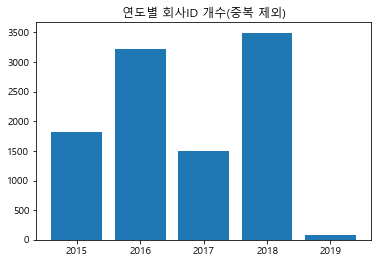

In [170]:
# 연도별 회사ID 개수 추출 및 시각화

x = []
y = []

for k, v in df_v2.groupby("년도")["회사ID"]:
    v = v. unique()  # 회사ID 중복 제외
    count = len(v)  # 회사ID 개수 정보 저장
    x.append(k)  # 해당 연도 정보 list에 추가
    y.append(count)  # 연도별 회사 개수 정보 list에 추가
    print(f"{k}년 : 총 {count}개 회사 (세부내역 : {v})")

plt.bar(x, y)
plt.title("연도별 회사ID 개수(중복 제외)")
plt.show()

In [171]:
# 시작시점 및 종료시점 기준 회사ID 개수 세부 파악(1차) => 1~2년 내의 단기적인 data만 있는 회사ID개수가 상당히 많은 것으로 나타남

#df_info["Start_date"].value_counts()  # 시작시점 기준 개수
#df_info["End_date"].value_counts()  # 종료시점 기준 개수
df_info.value_counts().head(20)  # 시작시점 및 종료시점 조합에 따른 개수

Start_date  End_date  
2018-01-01  2018-12-01    1180
2015-11-01  2018-12-01    1154
2016-01-01  2018-12-01     734
            2016-12-01     620
2015-11-01  2016-12-01     239
            2015-12-01     199
2016-01-01  2017-12-01     134
2015-11-01  2017-12-01     121
2018-02-01  2018-12-01      46
2015-11-01  2019-12-01      30
2018-11-01  2018-12-01      28
2018-05-01  2018-12-01      26
2015-12-01  2017-12-01      26
2018-04-01  2018-12-01      26
2018-06-01  2018-12-01      25
2018-07-01  2018-12-01      19
2018-09-01  2018-12-01      19
2018-08-01  2018-12-01      18
2016-02-01  2016-12-01      18
2018-03-01  2018-12-01      17
dtype: int64

In [172]:
# 시작시점 및 종료시점 기준 회사ID 개수 세부 파악(2차) => 각 시점별 세부내역 현황 확인

#df_info[df_info["End_date"] >= "2019-01-01"].value_counts()  # 종료시점이 2019년 1월이후인 내역 정보 확인
#df_info[df_info["End_date"] <= "2018-12-01"].value_counts()  # 종료시점이 2018년 12월 이전인 내역 정보 확인
df_info[df_info["Start_date"] <= "2016-01-01"].value_counts()  # 시작시점이 2016년 1월 이전인 내역 정보 확인

Start_date  End_date  
2015-11-01  2018-12-01    1154
2016-01-01  2018-12-01     734
            2016-12-01     620
2015-11-01  2016-12-01     239
            2015-12-01     199
2016-01-01  2017-12-01     134
2015-11-01  2017-12-01     121
            2019-12-01      30
2015-12-01  2017-12-01      26
            2018-12-01      14
2016-01-01  2019-12-01      14
2015-12-01  2016-12-01      13
            2015-12-01      11
2016-01-01  2016-05-01       3
            2016-04-01       3
            2016-11-01       2
            2016-02-01       2
            2016-09-01       2
2015-11-01  2018-08-01       2
            2018-11-01       2
            2016-11-01       2
2016-01-01  2016-03-01       2
            2017-09-01       1
            2017-10-01       1
            2017-11-01       1
2015-11-01  2017-10-01       1
            2016-07-01       1
2016-01-01  2018-02-01       1
            2017-04-01       1
            2018-04-01       1
            2018-07-01       1
            2018

### 유니콘 기업인지 여부를 판단하기 위한 최소한의 기간 설정 : 2016년 1월 ~ 2018년 12월
* 최소기간 설정 => 3년
 - 시작시점 : 2016년 1월 이전
 - 종료시점 : 2018년 12월 이후<br/>
    ※ 최근 시점인 2019년의 경우 data가 유독 적은 이유에 대한 확인이 필요하나, 본 프로젝트에서는 각 회사의 실제 유지여부와 상관없이 2019년 data내역들이 제대로 추출되지 않은 것으로 가정함
* 기간 설정 근거
 - 연매출액 등 지표에 대한 의미있는 변화 추이 파악을 위해 최소 3개년도에 걸친 data 필요
 - 최근 중소벤처기업부에서 선정한 거대신생기업(60개사)의 평균 업력이 3.7년인 점 함께 고려<br/>
 (참조 : https://www.mss.go.kr/site/smba/ex/bbs/View.do?cbIdx=86&bcIdx=1026739)

### 위 기간에 해당하는 회사ID 추출 => 총 1946개

In [173]:
# 시작시점(2016년 1월 이전) 및 종료시점(2018년 12월 이후) 기준 해당 회사ID 추출
df_cand = df_info[df_info["End_date"] >= "2018-12-01"]  # 종료시점 2018년 12월 이후 data만 추출
df_cand = df_cand[df_cand["Start_date"] <= "2016-01-01"]  # 시작시점 2016년 1월 이전 data만 추출
df_cand.value_counts()  # 추출된 data 기준으로 기간별 분포 확인

Start_date  End_date  
2015-11-01  2018-12-01    1154
2016-01-01  2018-12-01     734
2015-11-01  2019-12-01      30
2015-12-01  2018-12-01      14
2016-01-01  2019-12-01      14
dtype: int64

### 추출된 회사ID 중, 시작시점과 종료시점 사이에 매달 data가 빠짐없이 있는지 체크 => 최종 총 1096개 회사ID 추출

In [174]:
# 시작시점과 종료시점간의 기간(월) 산출 함수 정의
def get_period_count(id_v, start_date, end_date):
    diff_year = end_date.year - start_date.year
    diff_month = end_date.month - start_date.month
    
    return diff_year * 12 + diff_month + 1

# 중간에 data가 매달 빠짐없이 있는지 여부 체크
def check_drop_id(id_v):
    data_count = df_v2[df_v2["회사ID"] == id_v]["회사ID"].count()  # 회사ID 기준으로 존재하는 data 개수 세기
    period_count = get_period_count(id_v, df_cand.loc[id_v]["Start_date"], df_cand.loc[id_v]["End_date"])  # 기간(월) 계산

    result = 0
    if data_count != period_count:
        #print(f"[{id_v}] id_count : {id_count}, period_count : {period_count}")
        result = 1
    
    return result

In [175]:
# 시작시점과 종료시점 사이에 data가 없는 기간이 한달 이상 존재하는 회사ID 추출 => 850개 회사ID 확인 완료

drop_id_list = []

for id_v in df_cand.index:
    if check_drop_id(id_v):
        drop_id_list.append(id_v)
        
len(drop_id_list)

850

In [176]:
# 기존에 추출한 회사ID 데이터프레임(df_cand)에서 위 850개 회사ID 없애기

for id_v in drop_id_list:
    df_cand.drop(id_v, axis=0, inplace=True)
    
df_cand.value_counts()  # 최종 추출된 data 기준으로 기간별 분포 재확인

Start_date  End_date  
2015-11-01  2018-12-01    797
2016-01-01  2018-12-01    274
2015-11-01  2019-12-01     14
2015-12-01  2018-12-01      7
2016-01-01  2019-12-01      4
dtype: int64

In [177]:
df_cand.sort_index()  # 인덱스 기준 오름차순 정렬

len(df_cand.index)  # 추출된 회사ID 개수 확인

1096

### 추출된 회사ID에 해당되지 않는 행 삭제한 신규 데이터프레임 생성 => "df_v3"

In [178]:
# 데이터프레임에서 삭제할 행 index 정보 추출
df_v3 = df_v2
drop_index = []  # 삭제할 index 정보 저장용 리스트 선언

for i in df_v3.index[:]:
    v = df_v3.iloc[i]["회사ID"]  # 각 행 회사ID 정보 저장
    if v in df_cand.index:
        continue
    else:
        drop_index.append(i)  # df_cand에 해당하지 않을 경우 drop_index 리스트에 추가

In [179]:
drop_index[:20]  # 저장된 정보 확인

[2, 5, 6, 10, 11, 14, 15, 17, 18, 21, 24, 25, 26, 27, 28, 29, 32, 34, 37, 39]

In [180]:
# 해당 행 삭제 진행 => 삭제 결과, 기존 99801행에서 41301행으로 줄어든 것을 확인
for v in drop_index:
    df_v3.drop(v, axis=0, inplace=True)

In [181]:
df_v3.shape

(41301, 10)

In [182]:
len(df_v3["회사ID"].unique())  # 회사ID 개수 1096개 확인

1096

In [183]:
df_v3.head(10)  # df_v3 출력 결과 확인

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균),연월일,Start_date,End_date
0,233757,41688077,2018,7,8912380,36,247566,2018-07-01,2015-11-01,2018-12-01
1,123464,1760695,2018,3,942380,5,188476,2018-03-01,2016-01-01,2018-12-01
3,386420,4815584,2015,11,3795900,14,271135,2015-11-01,2015-11-01,2018-12-01
4,129243,9799736,2018,10,40724680,151,269699,2018-10-01,2015-11-01,2018-12-01
7,189562,7119908,2016,1,1276900,6,212816,2016-01-01,2015-11-01,2018-12-01
8,133518,18642904,2018,10,16844840,75,224597,2018-10-01,2015-11-01,2018-12-01
9,190847,2367117,2015,12,2354660,8,294332,2015-12-01,2015-11-01,2018-12-01
12,295938,13589790,2016,12,13187980,66,199817,2016-12-01,2016-01-01,2018-12-01
13,311326,3578929,2016,2,1931260,8,241407,2016-02-01,2016-01-01,2018-12-01
16,182436,2289741,2016,4,2515200,9,279466,2016-04-01,2015-11-01,2018-12-01


### 추가적으로, 모든 회사ID의 data가 빠짐없이 있는 3개년(2016년 1월 ~ 2018년 12월) data 기준 데이터프레임 생성
    => 회사별 동일한 기간을 기준으로 비교/분석하기 위함

In [184]:
# 3개년 기준 데이터프레임(df_v4) 생성 => 기존 41301행에서 39456행으로 줄어든 것을 확인

df_v4 = df_v3

df_v4 = df_v4[df_v4["연월일"] <= "2018-12-01"]  # "연월일" 값 기준, 2018년 12월 이전 data 저장
df_v4 = df_v4[df_v4["연월일"] >= "2016-01-01"]  # "연월일" 값 기준, 2016년 1월 이후 data 저장

df_v4.shape

(39456, 10)

In [185]:
len(df_v4["회사ID"].unique())  # 회사ID개수는 기존과 동일하게 1096개인 것을 확인

1096

In [186]:
df_v4.head(10)

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균),연월일,Start_date,End_date
0,233757,41688077,2018,7,8912380,36,247566,2018-07-01,2015-11-01,2018-12-01
1,123464,1760695,2018,3,942380,5,188476,2018-03-01,2016-01-01,2018-12-01
4,129243,9799736,2018,10,40724680,151,269699,2018-10-01,2015-11-01,2018-12-01
7,189562,7119908,2016,1,1276900,6,212816,2016-01-01,2015-11-01,2018-12-01
8,133518,18642904,2018,10,16844840,75,224597,2018-10-01,2015-11-01,2018-12-01
12,295938,13589790,2016,12,13187980,66,199817,2016-12-01,2016-01-01,2018-12-01
13,311326,3578929,2016,2,1931260,8,241407,2016-02-01,2016-01-01,2018-12-01
16,182436,2289741,2016,4,2515200,9,279466,2016-04-01,2015-11-01,2018-12-01
19,129310,43360251,2018,9,37862680,149,254111,2018-09-01,2015-11-01,2018-12-01
20,124181,2388433,2016,4,863000,5,172600,2016-04-01,2016-01-01,2018-12-01


### 데이터 정제 작업 완료
* 3개년(2016년 1월 ~ 2018년 12월, 총 36개월) 기간 동안 한달도 빠짐없이 data가 연속적으로 존재하는 회사ID 기준 data 추출 완료("df_v4")
  - 회사ID 개수(중복 제외) : 총 1096개
  - DataFrame 형태 : 39456행, 10열
  
    => 해당 DataFrame을 기준으로 세부 지표별 변화 추이 분석을 통해 유니콘 기업 선정기준을 검토하고자 함

# 3. 주요 지표 설정 및 지표별 분석
     => 유니콘 기업 선정을 위한 주요 지표 3가지 설정 : "연매출액", "직원수", "인당_연금보험료(평균)"
     => 각 지표에 대한 분석 및 유니콘 기업 선정기준(안) 검토

### 지표1. 연매출액
- "연매출액"을 통해 아래 3가지 세부지표를 산출한 뒤, 각 세부지표별로 가중치 점수를 부여해 유니콘 기업 후보 리스트 추출
- 세부지표 3가지<br/>
  1) 연평균성장률(CAGR)<br/>
  2) 3개년 지속성장 여부<br/>
  3) 3개년 평균매출

In [187]:
# 연도별 연매출액 추이 시각화 함수 정의 => 필요시점에 활용
def show_sales(id_num, total=False, w=10, h=5):
    infos = 0
    for k, v in df_v3.groupby("회사ID"):
        if k == id_num:
            infos = v
    
    if total == False:    # default로 2016년~2018년 기준 그래프 출력하도록 설정
        start_year = 2016
        end_year = 2018
    else:                  # "total == True"일 경우, 해당 회사ID의 전체기간 반영한 그래프 출력하도록 설정
        start_year = infos["Start_date"].tolist()[0].year
        end_year = infos["End_date"].tolist()[0].year
    
    x = [x for x in range(start_year, end_year + 1)]
    y = []
    
    for year_v in range(start_year, end_year + 1):
        year_sales = infos[infos["년도"] == year_v]["연매출액"].tolist()[0]
        y.append(year_sales)

    plt.figure(figsize=(w,h))
    plt.bar(x, y, align="edge")
    cagr_v = df_cand.loc[id_num, "16_18_cagr(%)"]
    if cagr_v == 0:
        plt.title(f"연도별 매출액 추이(회사ID : {id_num})")
    else:
        plt.title(f"연도별 매출액 추이(회사ID : {id_num}, CAGR(%) : {cagr_v})")
    plt.show()

### 연매출액 - 세부지표 1) 연평균성장률(CAGR)

**연평균성장률(CAGR) 산출**
* 회사별 2016년말부터 2018년말까지 2년의 기간동안 매출의 평균성장률 지표 산출
* 산출식 : (2018년 매출액 / 2016년 매출액) ** (1/2) - 1

    => CAGR 산출 과정에서, 3개년 매출액 평균 및 전년 대비 매출하락 구간 존재여부도 함께 파악 진행
    
**연평균성장률(CAGR)에 대한 가중치 점수 기준(안)**<br/>

    => CAGR 최소 20% 이상인 회사별로 수치가 높을수록 점수 차등 적용

In [188]:
# 회사ID별 3개년 매출 연평균성장률(CAGR) 계산한 뒤, "df_cand" 데이터프레임에 해당 Column 추가

df_cand["16_18_cagr(%)"] = 0  # "16_18_cagr(%)" Column 추가
df_cand["16_18_매출평균(천원)"] = 0  # "16_18_매출평균" Column 추가
df_cand["지속성장"] = False  # 전년 대비 매출하락 구간 존재여부 확인을 위한 "지속성장" Column 추가(True or False)

for id_v, v in df_v4.groupby("회사ID"):
    year_sales = [0,0,0]

    for year, v2 in v.groupby("년도"):
        if year == 2016:
            year_sales[0] = v2["연매출액"].tolist()[0]
        elif year == 2017:
            year_sales[1] = v2["연매출액"].tolist()[0]
        else:
            year_sales[2] = v2["연매출액"].tolist()[0]

    sales_cagr = (year_sales[2] / year_sales[0])**(1/2) - 1  # cagr 산출
    sales_cagr *= 100
    sales_cagr = round(sales_cagr, 1)

    df_cand.loc[id_v, "16_18_cagr(%)"] = sales_cagr
    
    # 3개년 매출평균 정보 저장
    df_cand.loc[id_v, "16_18_매출평균(천원)"] = int(sum(year_sales) / len(year_sales))
    
    # 전년 대비 매출하락 구간 존재여부 파악 및 정보 저장
    if year_sales[0] < year_sales[1] and year_sales[1] < year_sales[2]:
        df_cand.loc[id_v, "지속성장"] = True

df_cand.head(10)

,Start_date,End_date,16_18_cagr(%),16_18_매출평균(천원),지속성장
14271,2015-11-01,2019-12-01,40.4,5883788,True
59533,2015-11-01,2018-12-01,-16.6,158891,False
122968,2015-11-01,2018-12-01,8.3,30457037,False
123082,2016-01-01,2018-12-01,-5.8,6468566,False
123219,2016-01-01,2018-12-01,-0.7,3796056,False
123235,2015-11-01,2018-12-01,-0.8,15904838,False
123464,2016-01-01,2018-12-01,-2.5,1753749,False
123649,2016-01-01,2018-12-01,0.7,2157287,False
123882,2016-01-01,2018-12-01,328.0,2209185,True
124181,2016-01-01,2018-12-01,-11.2,2058772,False


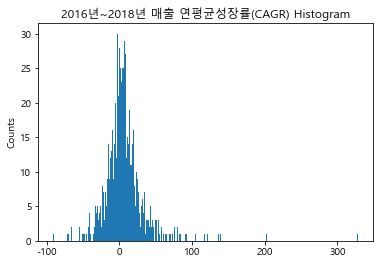

In [189]:
# 연평균성장률 분포 현황 파악
plt.hist(df_cand["16_18_cagr(%)"], bins=500)
plt.ylabel("Counts")
plt.title("2016년~2018년 매출 연평균성장률(CAGR) Histogram")
plt.show()

In [190]:
# 연평균성장률 분포 현황 파악 => 75% 수준이 17.0으로 유니콘 기업 선정을 위해서는 최소 20.0을 초과한 회사에 가중치 차등 부여 필요
df_cand["16_18_cagr(%)"].describe()

count   1096.0
mean       7.3
std       28.5
min      -90.5
25%       -6.2
50%        4.8
75%       17.0
max      328.0
Name: 16_18_cagr(%), dtype: float64

### 연매출액 - 세부지표 2) 3개년 지속성장 여부
    => 3개년 동안 성장세가 유지되지 않고 매출이 꺾인 시점이 존재할 경우 차감 점수 반영

In [191]:
# "16_18_cagr(%)" 기준 상위 20개 회사ID 확인 => 100%를 초과하는 회사ID 14개로 확인되며, 그 중 "지속성장"값이 False인 내역 일부 존재함
r = df_cand.sort_values(by="16_18_cagr(%)", ascending=False)
r.head(20)

,Start_date,End_date,16_18_cagr(%),16_18_매출평균(천원),지속성장
123882,2016-01-01,2018-12-01,328.0,2209185,True
435512,2015-11-01,2018-12-01,246.9,27848939,True
306768,2016-01-01,2018-12-01,202.7,14755906,True
155877,2016-01-01,2018-12-01,142.6,5372742,True
442467,2015-11-01,2019-12-01,139.5,12565474,False
470994,2016-01-01,2018-12-01,136.5,2848407,True
335237,2016-01-01,2018-12-01,121.6,2489825,False
405759,2016-01-01,2018-12-01,117.1,9673776,True
238384,2016-01-01,2018-12-01,105.4,3646191,True
247210,2015-11-01,2018-12-01,105.3,1221275,False


<Figure size 432x288 with 0 Axes>

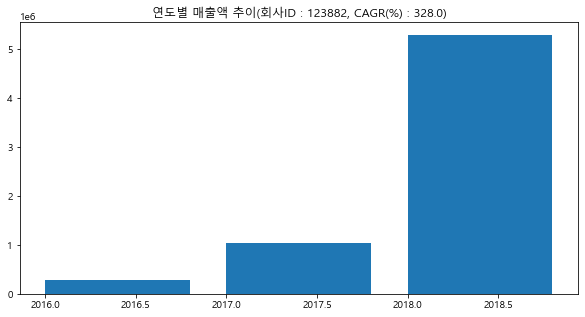

<Figure size 432x288 with 0 Axes>

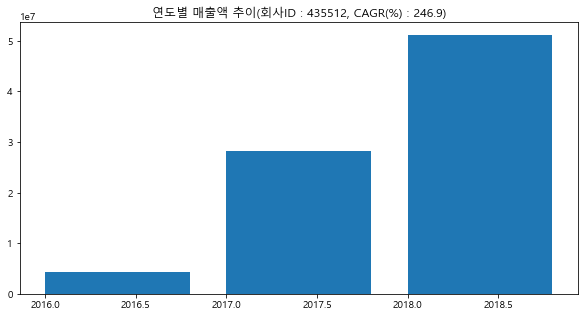

<Figure size 432x288 with 0 Axes>

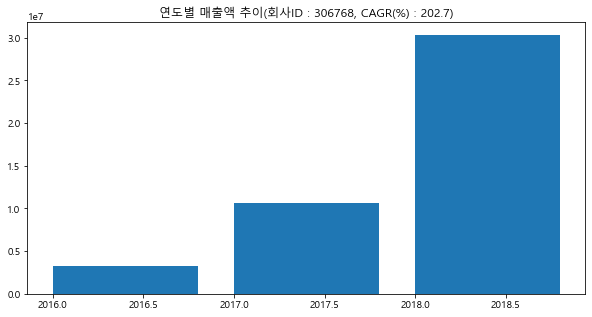

<Figure size 432x288 with 0 Axes>

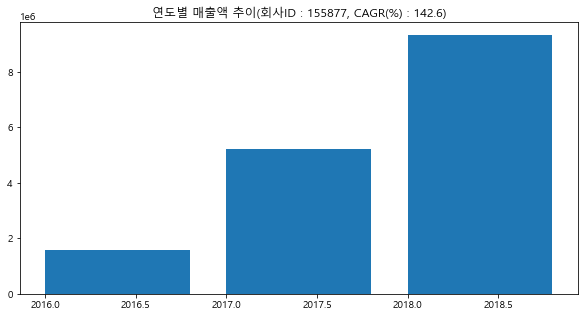

<Figure size 432x288 with 0 Axes>

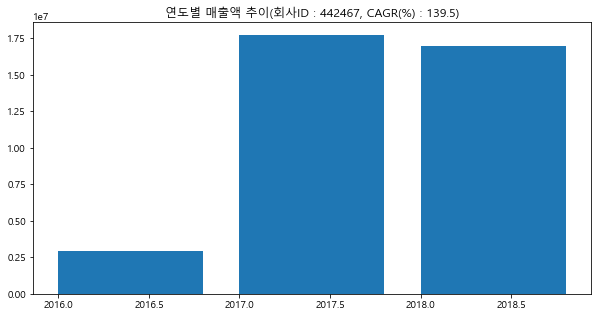

<Figure size 432x288 with 0 Axes>

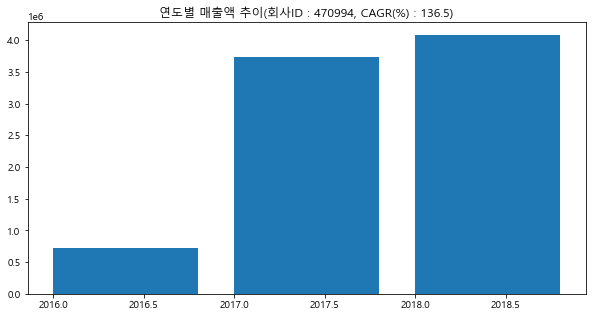

<Figure size 432x288 with 0 Axes>

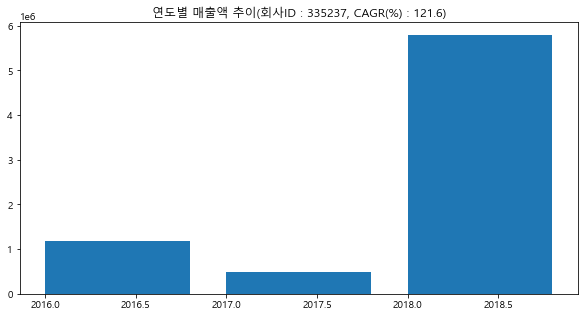

<Figure size 432x288 with 0 Axes>

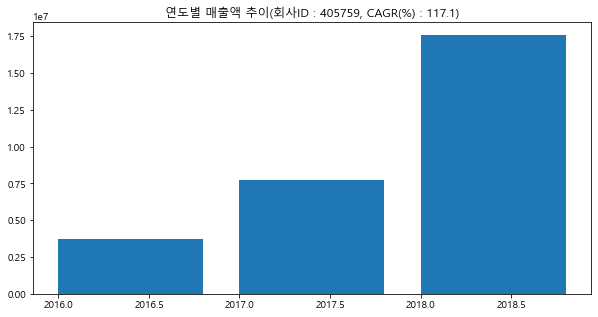

<Figure size 432x288 with 0 Axes>

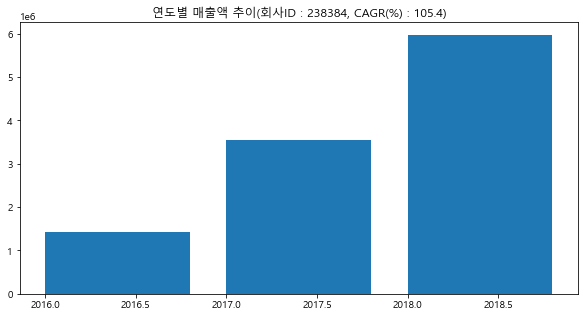

<Figure size 432x288 with 0 Axes>

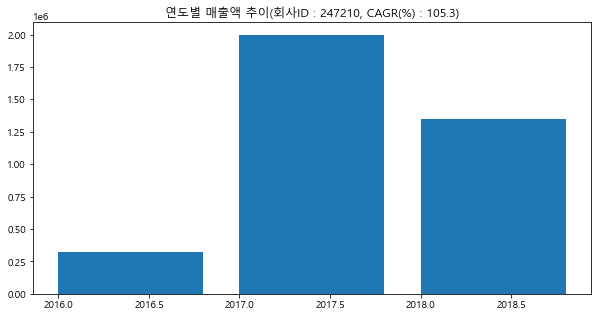

<Figure size 432x288 with 0 Axes>

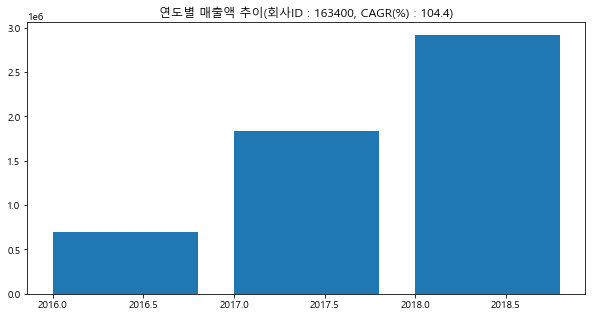

<Figure size 432x288 with 0 Axes>

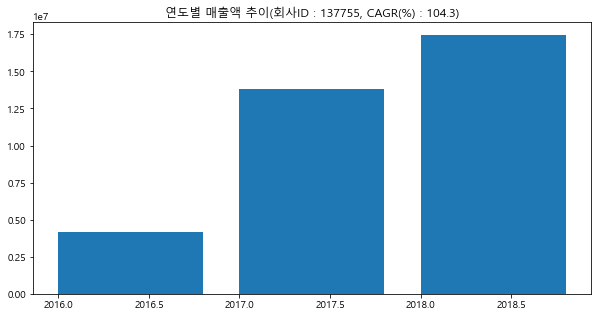

<Figure size 432x288 with 0 Axes>

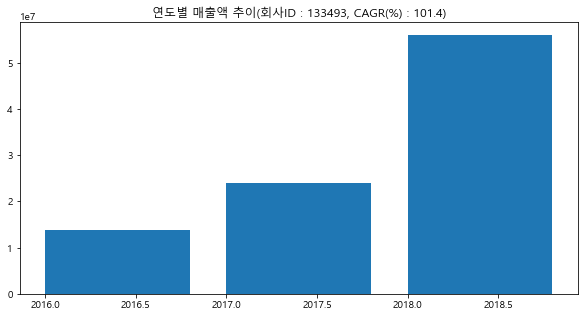

<Figure size 432x288 with 0 Axes>

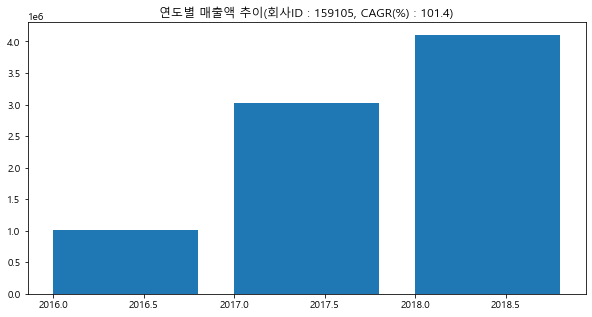

In [192]:
# 해당 14개 회사ID별 연도별 매출 현황 그래프 확인 => 연도별 증가 및 감소 시각적으로 확인
for i, id_v in enumerate(r["16_18_cagr(%)"].index[:14]):
    plt.figure(i)
    show_sales(id_v)

### 연매출액 - 세부지표 3) 3개년 매출평균
    => 3개년 매출평균 최소 140억 이상인 회사별로 수치가 높을수록 차등 가중치 적용

In [193]:
# CAGR이 최소 20%이상인 회사ID 기준 매출평균 분포 확인 => 75%수준이 약 140억으로, 최소 140억 이상의 매출에 가중치 차등 부여 필요
df_cand[df_cand["16_18_cagr(%)"] >= 20]["16_18_매출평균(천원)"].describe()

count         231.0
mean     18112450.0
std      54339727.5
min        133183.0
25%       2256711.0
50%       5883788.0
75%      14036522.5
max     550836260.0
Name: 16_18_매출평균(천원), dtype: float64

In [194]:
# CAGR이 최소 20%이상인 회사ID 기준 매출평균 내림차순 정렬 후 현황 확인
r = df_cand[df_cand["16_18_cagr(%)"] >= 20].sort_values(by="16_18_매출평균(천원)", ascending=False)
r.head(20)

,Start_date,End_date,16_18_cagr(%),16_18_매출평균(천원),지속성장
126814,2015-11-01,2018-12-01,25.4,550836260,True
420046,2016-01-01,2018-12-01,23.8,497181958,True
232757,2015-11-01,2018-12-01,32.7,239227137,True
294337,2015-11-01,2018-12-01,40.1,208665281,True
127366,2015-11-01,2018-12-01,66.9,152172847,True
469677,2015-11-01,2018-12-01,33.8,84051480,True
420304,2016-01-01,2018-12-01,27.5,81421783,True
129370,2015-11-01,2018-12-01,26.0,77077111,True
403470,2015-11-01,2018-12-01,83.4,71971653,True
128264,2015-11-01,2018-12-01,28.5,62173964,True


### 각 세부지표에 대한 회사ID별 차등 점수 적용 및 3가지 세부지표가 종합된 "연매출액 점수" 산출
* CAGR, 매출평균 및 지속성장 여부에 따른 "연매출액 점수" 산출<br/>
    => 해당 Column 정보 데이터프레임에 추가
* "연매출액 점수" 산출 기준(안)
  - CAGR
    - CAGR 300% 이상 : 10점
    - CAGR 200% 이상 : 9점
    - CAGR 100% 이상 : 8점
    - CAGR 80% 이상 : 7점
    - CAGR 50% 이상 : 6점
    - CAGR 20% 이상 : 5점
    - CAGR 20% 미만 : 0점
  - 매출평균
    - 매출평균 1500억 이상 : 1.2배
    - 매출평균 1000억 이상 : 1.15배
    - 매출평균 500억 이상 : 1.1배
    - 매출평균 300억 이상 : 1.05배
    - 매출평균 140억 이상 : 1.0배
    - 매출평균 140억 미만 : 0.9배
  
  - 지속성장
    - False일 경우 -1점

In [195]:
# 연매출액 점수 산출 및 "df_cand" 데이터프레임에 반영

df_cand["연매출액_점수"] = 0

for id_v in df_cand.index:
    if df_cand.loc[id_v]["16_18_cagr(%)"] >= 300:
        df_cand.loc[id_v, "연매출액_점수"] = 10
    elif df_cand.loc[id_v]["16_18_cagr(%)"] >= 200:
        df_cand.loc[id_v, "연매출액_점수"] = 9
    elif df_cand.loc[id_v]["16_18_cagr(%)"] >= 100:
        df_cand.loc[id_v, "연매출액_점수"] = 8
    elif df_cand.loc[id_v]["16_18_cagr(%)"] >= 80:
        df_cand.loc[id_v, "연매출액_점수"] = 7
    elif df_cand.loc[id_v]["16_18_cagr(%)"] >= 50:
        df_cand.loc[id_v, "연매출액_점수"] = 6
    elif df_cand.loc[id_v]["16_18_cagr(%)"] >= 20:
        df_cand.loc[id_v, "연매출액_점수"] = 5
    else:
        df_cand.loc[id_v, "연매출액_점수"] = 0
    
    if df_cand.loc[id_v]["16_18_매출평균(천원)"] >= 150000000:
        df_cand.loc[id_v, "연매출액_점수"] *= 1.2
    elif df_cand.loc[id_v]["16_18_매출평균(천원)"] >= 100000000:
        df_cand.loc[id_v, "연매출액_점수"] *= 1.15
    elif df_cand.loc[id_v]["16_18_매출평균(천원)"] >= 50000000:
        df_cand.loc[id_v, "연매출액_점수"] *= 1.1
    elif df_cand.loc[id_v]["16_18_매출평균(천원)"] >= 30000000:
        df_cand.loc[id_v, "연매출액_점수"] *= 1.05
    elif df_cand.loc[id_v]["16_18_매출평균(천원)"] >= 14000000:
        df_cand.loc[id_v, "연매출액_점수"] *= 1.0
    else:
        df_cand.loc[id_v, "연매출액_점수"] *= 0.9
    
    
    if df_cand.loc[id_v]["지속성장"] == False:
        df_cand.loc[id_v, "연매출액_점수"] -= 1

In [196]:
# 반영 결과 확인
ret = df_cand.sort_values(by="연매출액_점수", ascending=False)
ret.head(20)

,Start_date,End_date,16_18_cagr(%),16_18_매출평균(천원),지속성장,연매출액_점수
306768,2016-01-01,2018-12-01,202.7,14755906,True,9.0
123882,2016-01-01,2018-12-01,328.0,2209185,True,9.0
435512,2015-11-01,2018-12-01,246.9,27848939,True,9.0
133493,2015-11-01,2018-12-01,101.4,31227491,True,8.4
403470,2015-11-01,2018-12-01,83.4,71971653,True,7.7
238384,2016-01-01,2018-12-01,105.4,3646191,True,7.2
137755,2016-01-01,2018-12-01,104.3,11811892,True,7.2
470994,2016-01-01,2018-12-01,136.5,2848407,True,7.2
405759,2016-01-01,2018-12-01,117.1,9673776,True,7.2
163400,2016-01-01,2018-12-01,104.4,1815929,True,7.2


### "연매출액_점수" 기준 상위 20개 회사ID 추출
* 상위 20개 회사ID => 306768, 123882, 435512, 133493, 403470, 238384, 137755, 470994, 405759, 163400, 159105, 155877, 127366, 297175, 132156, 404804, 296071, 232218, 405710, 171408

In [197]:
df_cand_final = ret.iloc[:20]
df_cand_final.index  # 상위 20개(유니콘 기업 후보) 회사ID 확인

Int64Index([306768, 123882, 435512, 133493, 403470, 238384, 137755, 470994,
            405759, 163400, 159105, 155877, 127366, 297175, 132156, 404804,
            296071, 232218, 405710, 171408],
           dtype='int64')

### 기존 데이터프레임 "df_v4"에 위에서 추출한 20개 회사ID 구분열 추가 : "Cand"
    => 해당여부에 따라 True 또는 False 값 입력
    => 이후 "직원수" 및 "인당_연금보험료(평균)" 지표 분석시 활용하기 위함

In [198]:
# "Cand" Column 추가 => True 또는 False 값 입력

df_v4["Cand"] = False

for i in df_v4.index:
    if df_v4.loc[i, "회사ID"] in df_cand_final.index:  # 위에서 추출된 20개 회사ID일 경우 True 입력
        df_v4.loc[i, "Cand"] = True

df_v4

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균),연월일,Start_date,End_date,Cand
0,233757,41688077,2018,7,8912380,36,247566,2018-07-01,2015-11-01,2018-12-01,False
1,123464,1760695,2018,3,942380,5,188476,2018-03-01,2016-01-01,2018-12-01,False
4,129243,9799736,2018,10,40724680,151,269699,2018-10-01,2015-11-01,2018-12-01,False
7,189562,7119908,2016,1,1276900,6,212816,2016-01-01,2015-11-01,2018-12-01,False
8,133518,18642904,2018,10,16844840,75,224597,2018-10-01,2015-11-01,2018-12-01,False
...,...,...,...,...,...,...,...,...,...,...,...
99791,442613,1513092,2017,3,3457380,20,172869,2017-03-01,2015-11-01,2018-12-01,False
99793,199954,1651504,2016,1,1414960,6,235826,2016-01-01,2016-01-01,2018-12-01,False
99795,150135,7119441,2016,12,4872520,25,194900,2016-12-01,2016-01-01,2018-12-01,False
99796,171439,4630622,2017,2,2402740,11,218430,2017-02-01,2015-11-01,2018-12-01,False


In [199]:
# 신규 데이터프레임 "df_v5"에 저장 및 현황 확인
df_v5 = df_v4[df_v4["Cand"] == True]
df_v5

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료(평균),연월일,Start_date,End_date,Cand
22,137755,13796240,2017,12,9385540,49,191541,2017-12-01,2016-01-01,2018-12-01,True
96,470994,729553,2016,9,1530980,7,218711,2016-09-01,2016-01-01,2018-12-01,True
214,297175,86707331,2018,11,21815200,60,363586,2018-11-01,2015-11-01,2018-12-01,True
262,155877,5207083,2017,1,1733740,8,216717,2017-01-01,2016-01-01,2018-12-01,True
471,123882,5293947,2018,9,1523160,6,253860,2018-09-01,2016-01-01,2018-12-01,True
...,...,...,...,...,...,...,...,...,...,...,...
99032,435512,51137355,2018,10,1521900,5,304380,2018-10-01,2015-11-01,2018-12-01,True
99035,405710,637948,2016,11,1470660,12,122555,2016-11-01,2015-11-01,2018-12-01,True
99088,133493,23896664,2017,1,15888580,57,278747,2017-01-01,2015-11-01,2018-12-01,True
99109,159105,4103086,2018,6,4473760,19,235461,2018-06-01,2015-11-01,2018-12-01,True


### 지표2. 월별_직원수
    => 각 연도별 "월별_직원수" 평균치를 산출한 뒤, 직원수가 지속적으로 상승한 회사ID만 최종 유니콘 기업 후보로 선정

### "월별_직원수" 기준 최종 유니콘 기업 후보 리스트 추출(1차) => 17개
* 최종 유니콘 기업 후보 리스트 회사ID => 123882, 127366, 132156, 133493, 137755, 155877, 159105, 163400, 232218, 296071, 297175, 306768, 403470, 404804, 405710, 405759, 470994

In [200]:
# 후보 회사ID별 직원수 월별 현황 전체 data 출력 및 전반적 추이 확인
df_v5.groupby(["회사ID", "연월일"])["월별_직원수"].sum().unstack()

연월일,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
회사ID,,,,,,,,,,,,,,,,,,,,,
123882,5,4,6,6,6,7,6,7,6,6,...,9,9,9,9,9,6,6,6,6,6
127366,244,248,251,246,251,251,246,250,250,250,...,303,318,319,322,320,325,324,321,321,317
132156,52,53,56,55,55,55,55,56,56,57,...,77,83,87,88,87,90,88,89,90,87
133493,44,45,45,48,48,48,52,54,56,55,...,70,70,69,69,77,80,83,85,85,91
137755,3,3,5,5,7,7,22,22,25,27,...,44,45,44,46,44,46,45,46,46,47
155877,6,6,6,7,7,7,8,7,7,7,...,21,21,20,20,20,21,21,21,22,26
159105,19,14,13,12,11,13,15,15,15,15,...,17,19,19,19,19,20,20,21,21,21
163400,5,7,8,10,10,14,12,8,9,9,...,15,14,13,17,17,19,17,20,19,20
171408,13,13,13,13,13,13,13,13,13,13,...,13,13,12,12,12,12,12,12,14,14


In [201]:
# 연평균 기준 3년 동안 직원수가 상승한 회사ID 추출

cand_list = []

for v in df_v5.groupby("회사ID"):
    id_v, v = v
    
    #dec = v[v["월"] == 12]
    직원수_16 = v[v["년도"] == 2016]["월별_직원수"].mean()
    직원수_17 = v[v["년도"] == 2017]["월별_직원수"].mean()
    직원수_18 = v[v["년도"] == 2018]["월별_직원수"].mean()
    연도별_직원수 = [직원수_16, 직원수_17, 직원수_18]
    #print(k, 연도별_직원수)
    if 직원수_16 < 직원수_17 and 직원수_17 < 직원수_18:
        cand_list.append(id_v)

print(len(cand_list))  # 최종 유니콘 기업 1차 후보 17개 추출
print(cand_list)

17
[123882, 127366, 132156, 133493, 137755, 155877, 159105, 163400, 232218, 296071, 297175, 306768, 403470, 404804, 405710, 405759, 470994]


### 17개 회사ID별 직원수 변동 현황 시각화
    => 3년 동안 지속적으로 우상향하는 경향을 나타내는 것을 확인

In [202]:
# 회사ID별 직원수 변동 그래프 확인을 위한 scatter 출력 함수 정의
def show_scatter(id_v, w=15, h=5):
    r = df_v5[df_v5["회사ID"] == id_v].sort_values(by="연월일")

    x = r["연월일"]
    y = r["월별_직원수"]

    plt.figure(figsize=(w,h))
    plt.title(f"월별_직원수 추이(회사ID : {id_v})")
    plt.scatter(x, y)
    plt.show()

<Figure size 432x288 with 0 Axes>

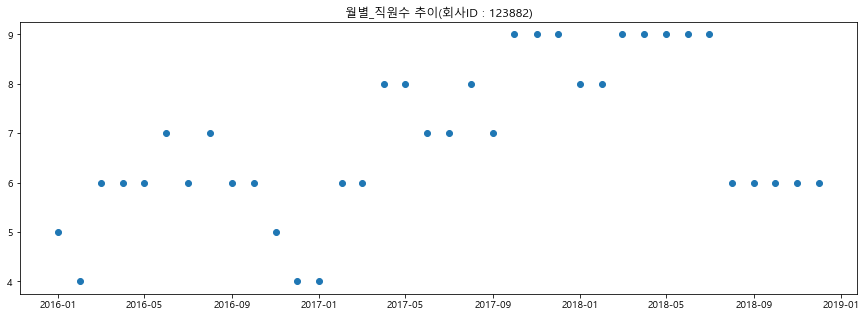

<Figure size 432x288 with 0 Axes>

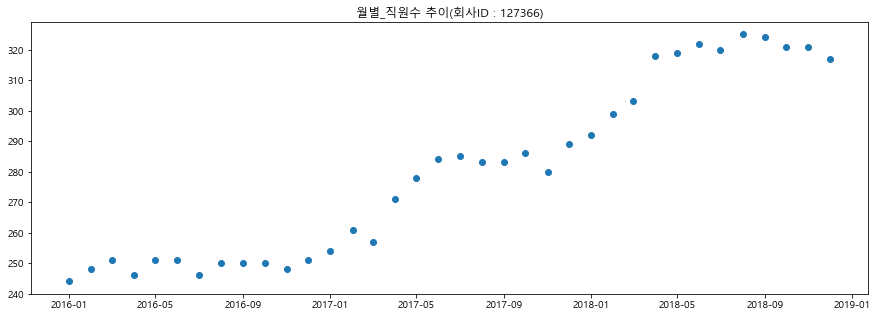

<Figure size 432x288 with 0 Axes>

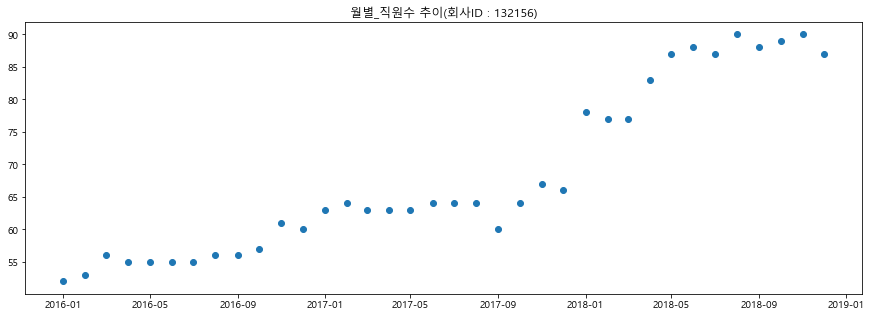

<Figure size 432x288 with 0 Axes>

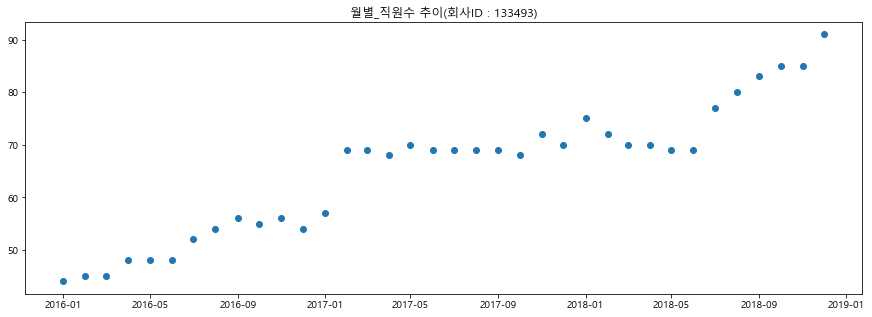

<Figure size 432x288 with 0 Axes>

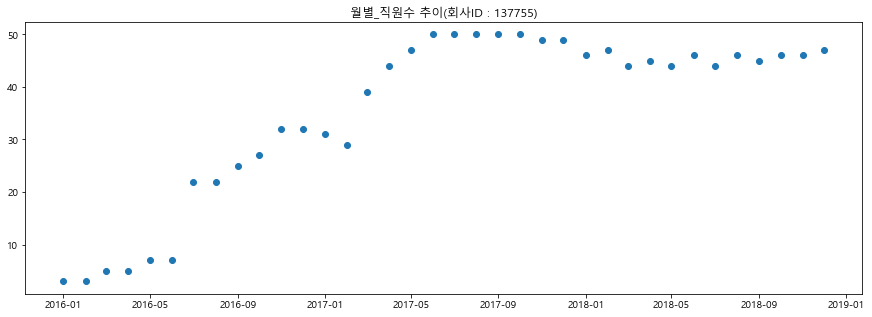

<Figure size 432x288 with 0 Axes>

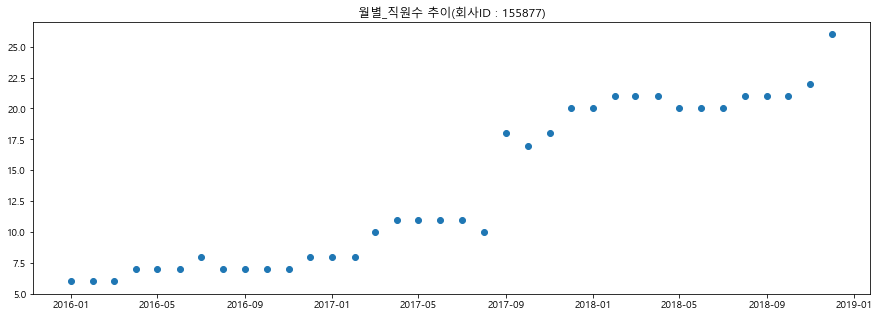

<Figure size 432x288 with 0 Axes>

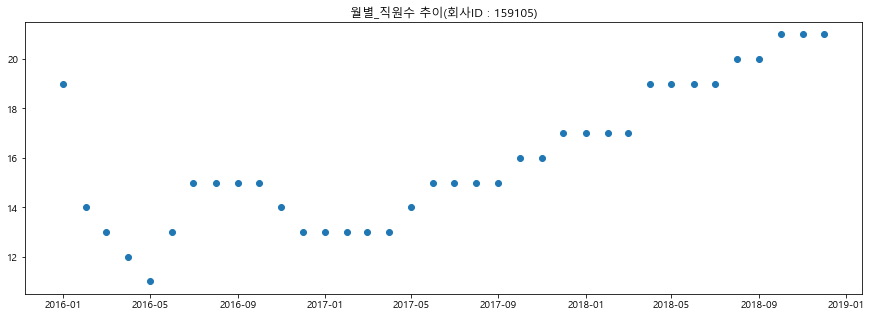

<Figure size 432x288 with 0 Axes>

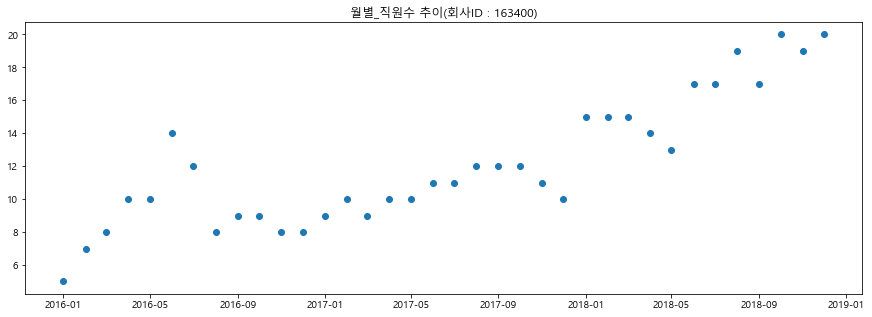

<Figure size 432x288 with 0 Axes>

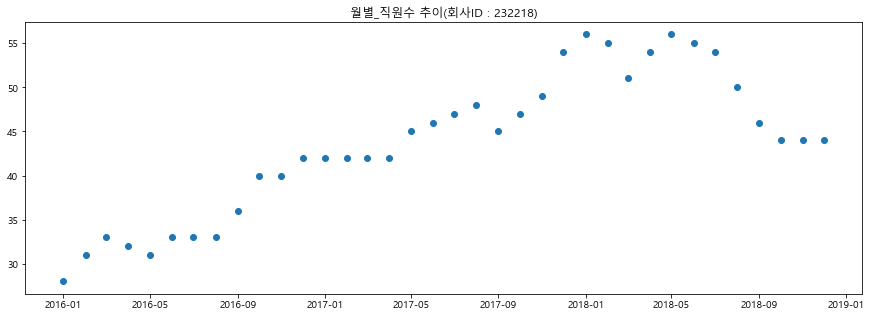

<Figure size 432x288 with 0 Axes>

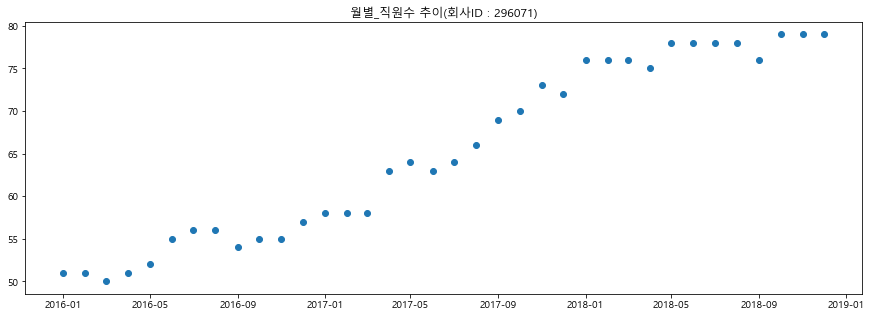

<Figure size 432x288 with 0 Axes>

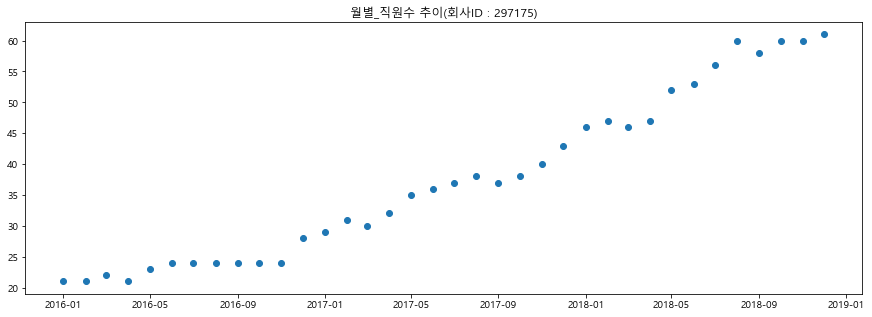

<Figure size 432x288 with 0 Axes>

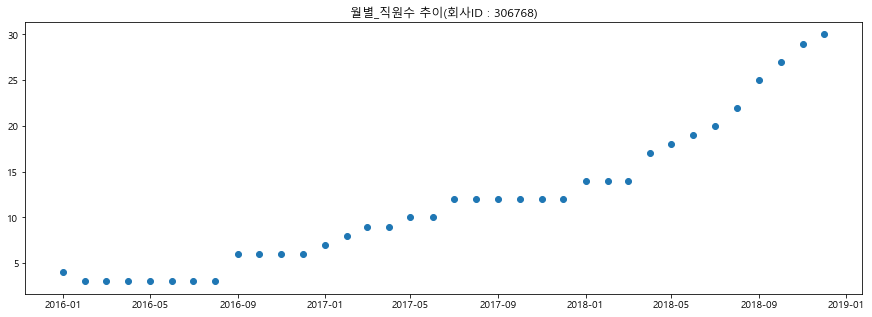

<Figure size 432x288 with 0 Axes>

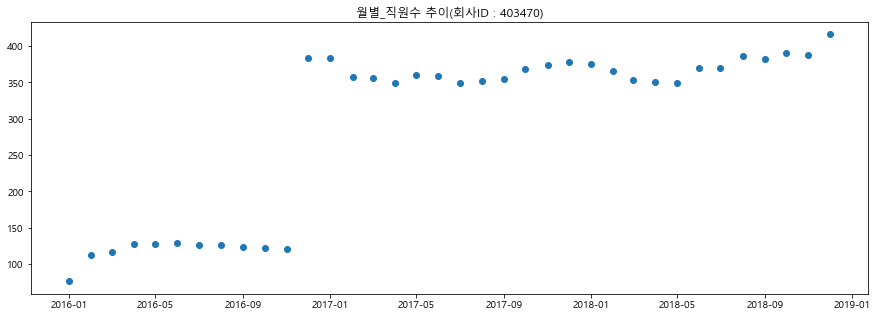

<Figure size 432x288 with 0 Axes>

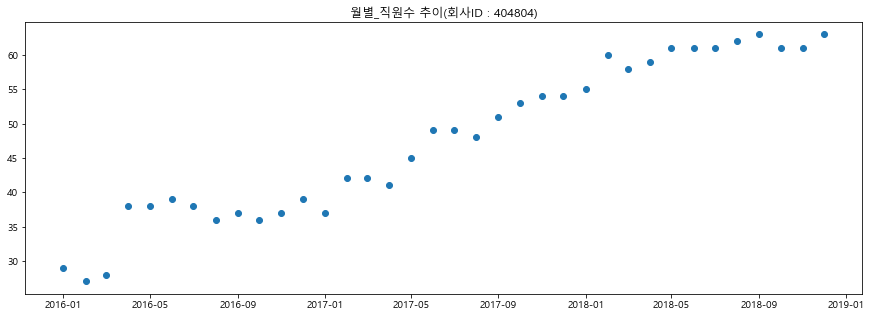

<Figure size 432x288 with 0 Axes>

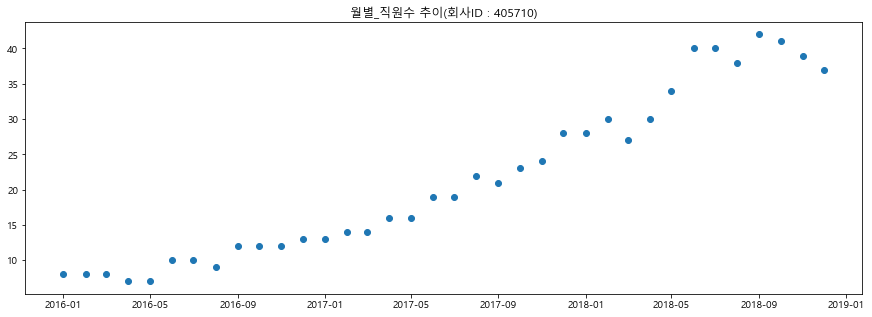

<Figure size 432x288 with 0 Axes>

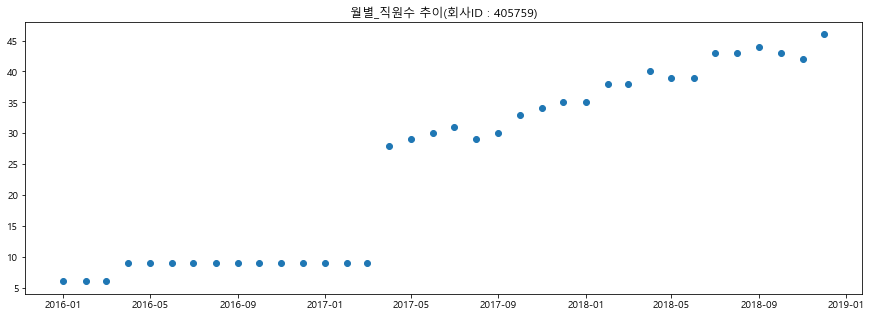

<Figure size 432x288 with 0 Axes>

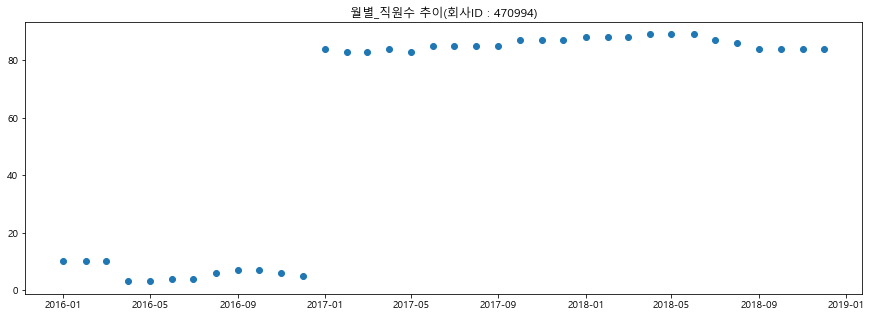

In [203]:
# 17개 회사ID의 월별 직원수 그래프를 통한 변동 추이 점검
for i, id_v in enumerate(cand_list):
    plt.figure(i)
    show_scatter(id_v)

In [216]:
# df_v5에 최종 후보인 17개 회사ID(cand_list)를 표시하는 Column 추가

df_v5["Semifinal"] = False

for i in df_v5.index:
    if df_v5.loc[i, "회사ID"] in cand_list:
        df_v5.loc[i, "Semifinal"] = True

df_v5[df_v5["Semifinal"] == True]["회사ID"].unique()  # 적용 결과 확인

array([137755, 470994, 297175, 155877, 123882, 405759, 403470, 405710,
       306768, 232218, 132156, 127366, 159105, 133493, 163400, 296071,
       404804], dtype=int64)

In [218]:
# 17개 회사ID만 추출한 신규 데이터프레임 "df_v6" 선언
df_v6 = df_v5[df_v5["Semifinal"] == True]

### 지표3. 인당_연금보험료(평균)
    => 해당 지표는 직원에 대한 평균급여 수준을 판단할 수 있는 지표로 3년간의 상대적 추이를 통해 검토할 필요가 있다고 판단

### "인당_연금보험료(평균)" 기준으로 회사ID별 전체적인 추이 확인
    => 확인 결과 연중에 특정 패턴을 보이는 움직임이 관찰되며, 각 연도의 평균치를 산출한 뒤 3개년의 추이를 살펴보는 것이 합리적이라고 판단
    => 대체적으로 상승하는 추세를 보이거나, 횡보 또는 하락하는 추이를 보이는 유형의 그래프들도 일부 관찰됨

In [219]:
# 전체 data 출력 및 확인
df_v6.groupby(["회사ID", "연월일"])["인당_연금보험료(평균)"].sum().unstack()

연월일,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,...,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
회사ID,,,,,,,,,,,,,,,,,,,,,
123882,150512,160580,178303,178303,178303,206960,228776,208951,178676,178676,...,173766,202766,202766,202766,206128,253860,253860,253860,253860,253860
127366,324135,324066,323499,322251,320514,320326,329379,328800,328548,327477,...,324288,321467,321836,323519,345566,343347,342999,344290,343261,343682
132156,184686,183658,181588,181332,181332,181332,220133,218632,218632,210797,...,215856,216942,219040,219041,254502,253518,252301,251994,251694,252133
133493,294058,291123,291873,286944,287506,287506,289141,288849,289248,290580,...,277842,277923,280658,280961,301560,304028,300792,301076,301076,296601
137755,180300,180300,259740,259740,256654,256654,222911,222870,205058,201462,...,186629,186281,187242,185246,226729,231518,232621,232492,232492,231369
155877,234013,234013,234013,219868,219868,219868,242930,232402,232402,228391,...,182810,182810,184526,190079,214665,220728,217964,217964,216239,209607
159105,247113,257244,256907,255636,264149,255356,245620,245620,245020,245020,...,235315,235461,235461,235461,244428,241207,234853,232240,232240,232240
163400,112896,108925,106560,113148,113148,114891,115361,124612,128826,128826,...,161777,163214,164692,161941,184741,180452,185408,181740,183252,181740
232218,239986,238602,236060,237170,239514,237860,241549,241436,242200,246386,...,240062,238155,240606,241444,262268,266632,267983,272480,273787,279449


<Figure size 432x288 with 0 Axes>

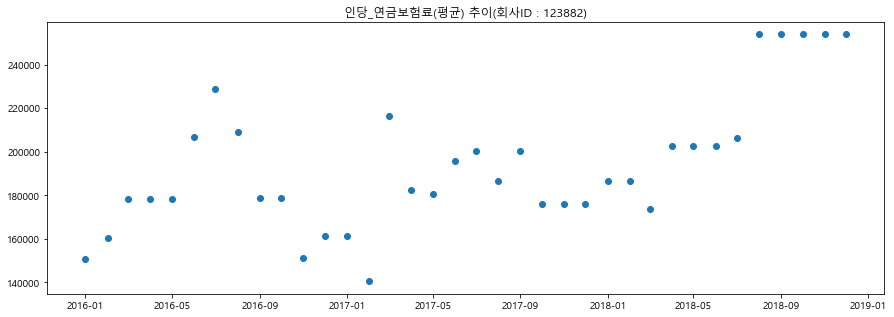

<Figure size 432x288 with 0 Axes>

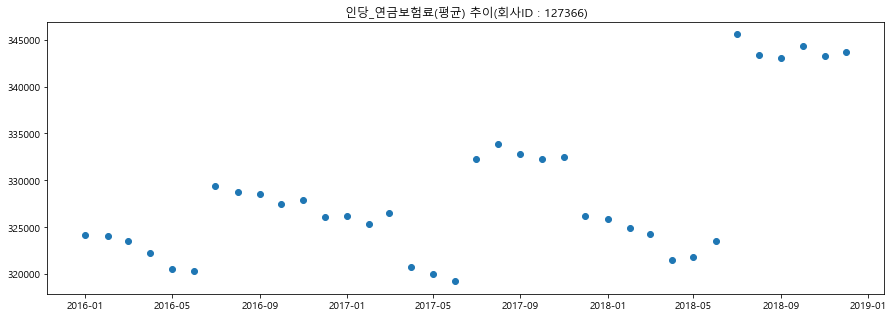

<Figure size 432x288 with 0 Axes>

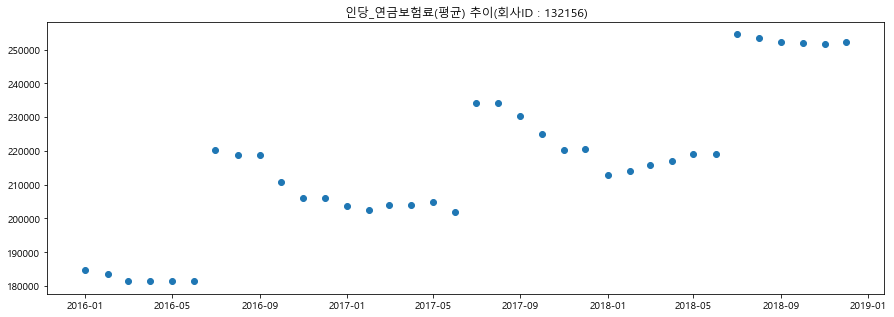

<Figure size 432x288 with 0 Axes>

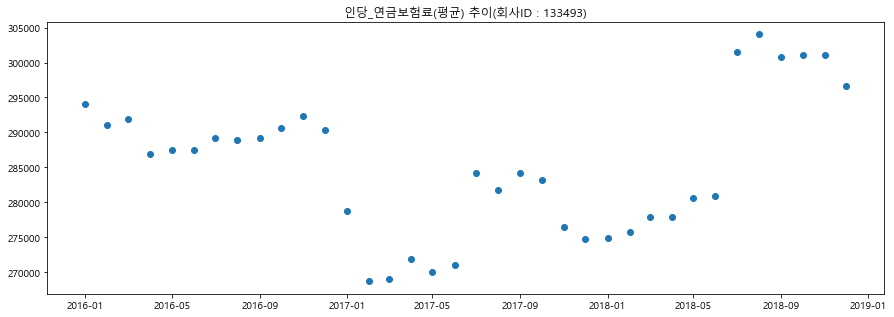

<Figure size 432x288 with 0 Axes>

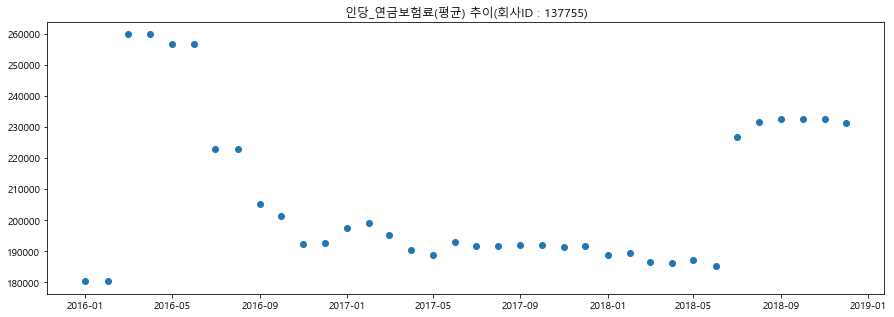

<Figure size 432x288 with 0 Axes>

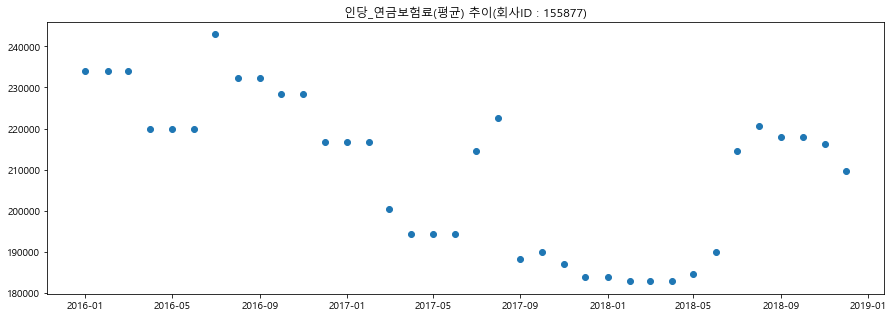

<Figure size 432x288 with 0 Axes>

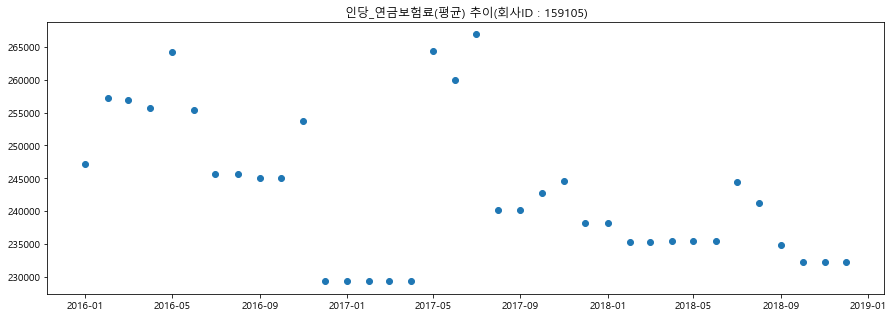

<Figure size 432x288 with 0 Axes>

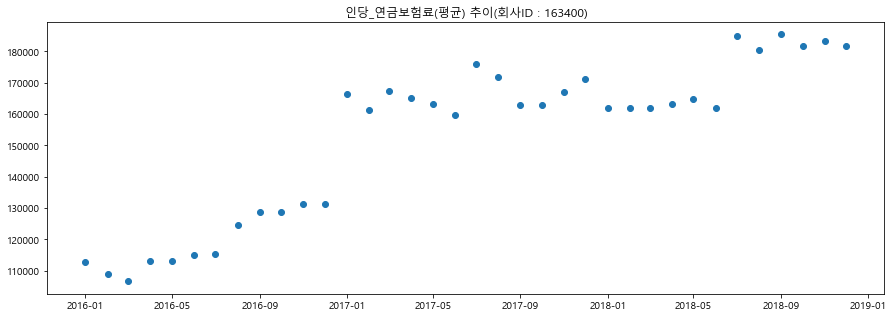

<Figure size 432x288 with 0 Axes>

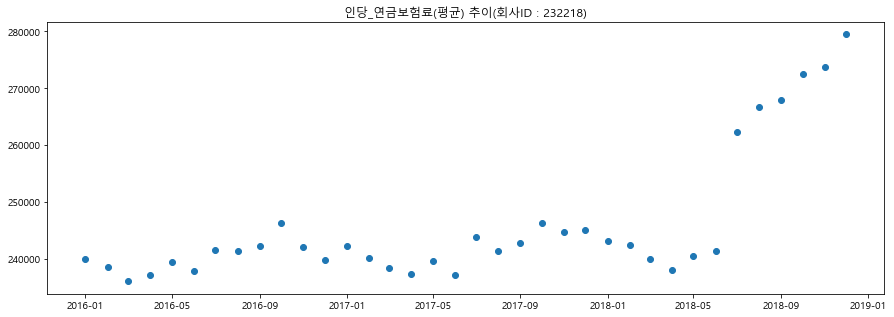

<Figure size 432x288 with 0 Axes>

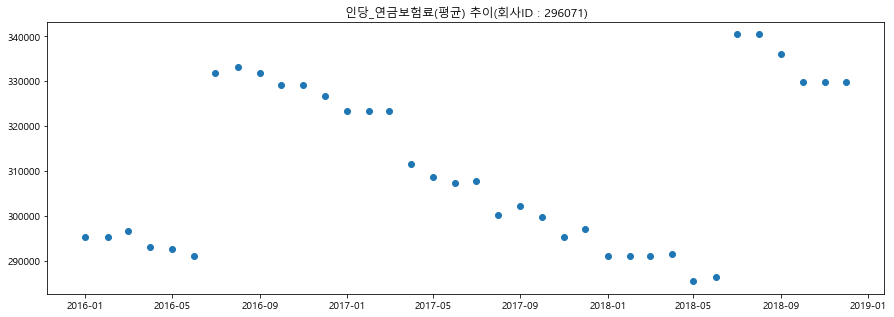

<Figure size 432x288 with 0 Axes>

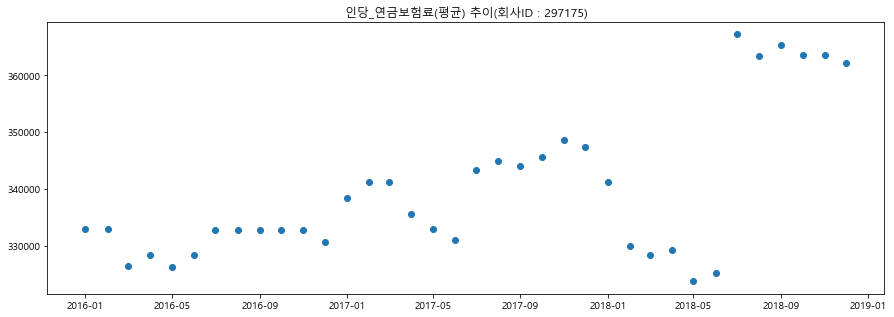

<Figure size 432x288 with 0 Axes>

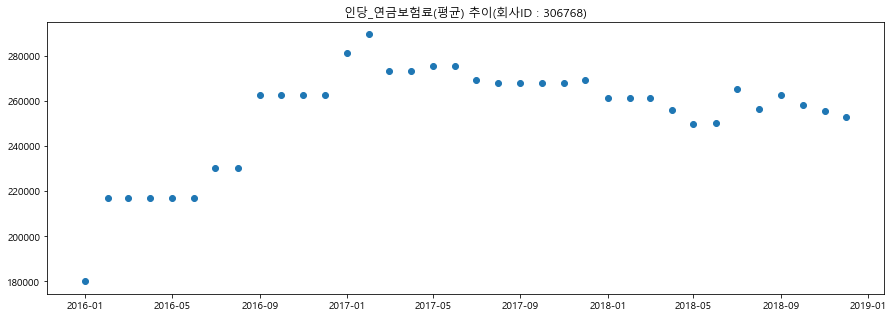

<Figure size 432x288 with 0 Axes>

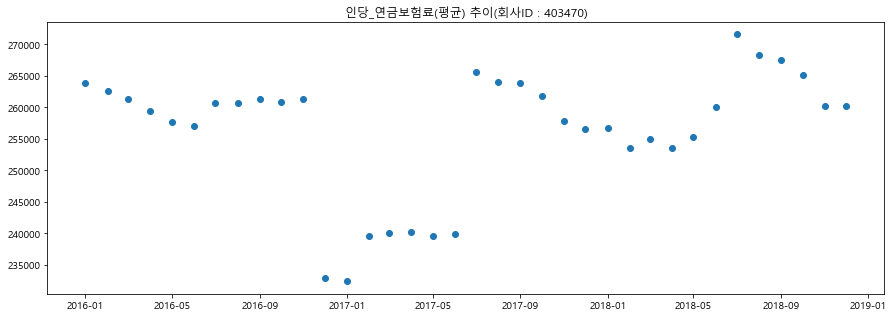

<Figure size 432x288 with 0 Axes>

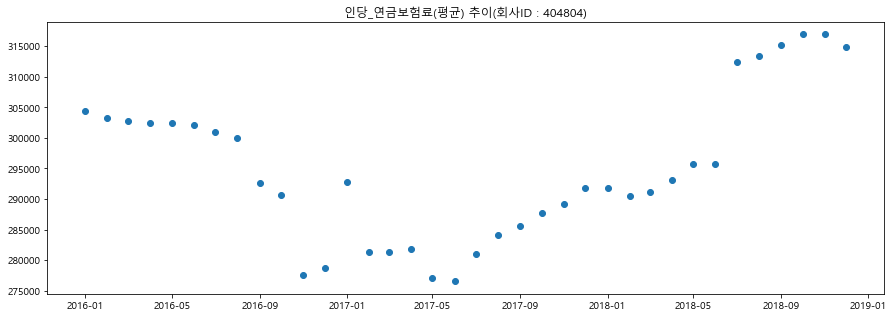

<Figure size 432x288 with 0 Axes>

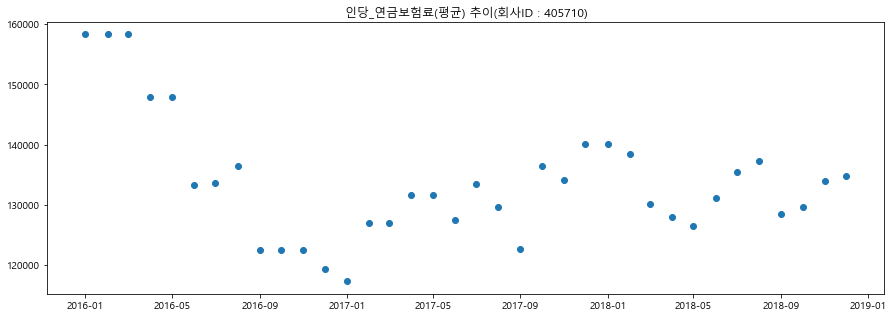

<Figure size 432x288 with 0 Axes>

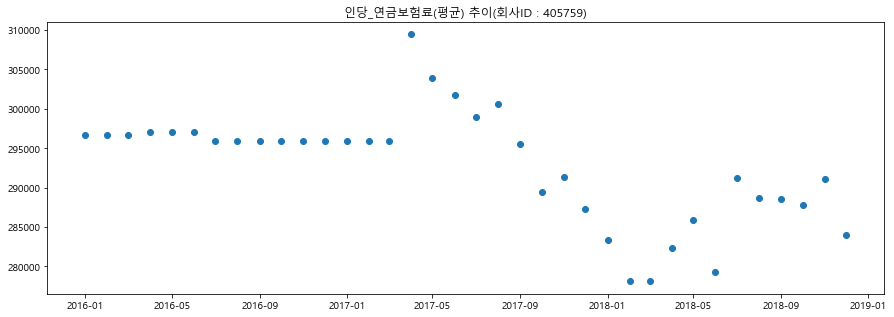

<Figure size 432x288 with 0 Axes>

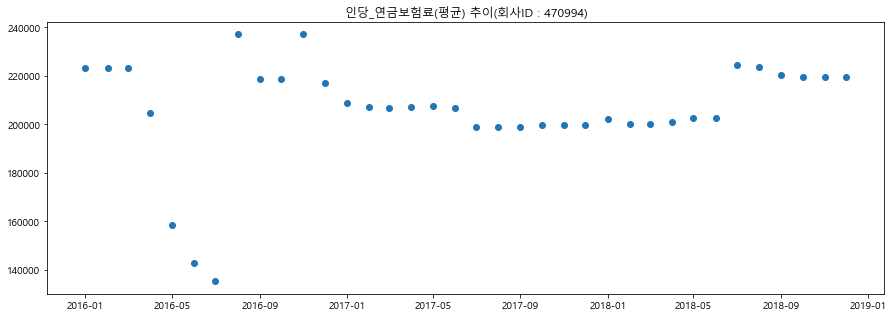

In [220]:
# 시각화를 통한 추이 확인 => 연중에 특정 패턴의 움직임 일부 관찰되며, 36개월 기간 동안의 전체적인 흐름 확인

def show_scatter_2(id_v, w=15, h=5):
    r = df_v6[df_v6["회사ID"] == id_v].sort_values(by="연월일")

    x = r["연월일"]
    y = r["인당_연금보험료(평균)"]

    plt.figure(figsize=(w,h))
    plt.title(f"인당_연금보험료(평균) 추이(회사ID : {id_v})")
    plt.scatter(x, y)
    plt.show()
    
for i, id_v in enumerate(cand_list):
    plt.figure(i)
    show_scatter_2(id_v)

### "인당_연금보험료(평균)" 기준 최종 유니콘 기업 선정 리스트 추출

In [221]:
# 각 연도별 평균치 기준 3년 동안 상승 추세인 회사ID 추출 => finalist로 저장

finalist = []

for v in df_v6.groupby("회사ID"):
    id_v, v = v
    
    연금보험료_16 = v[v["년도"] == 2016]["인당_연금보험료(평균)"].mean()
    연금보험료_17 = v[v["년도"] == 2017]["인당_연금보험료(평균)"].mean()
    연금보험료_18 = v[v["년도"] == 2018]["인당_연금보험료(평균)"].mean()
    연도별_연금보험료 = [연금보험료_16, 연금보험료_17, 연금보험료_18]
    #print(id_v, 연도별_연금보험료)

    if 연금보험료_16 < 연금보험료_17 and 연금보험료_17 < 연금보험료_18:
        finalist.append(id_v)

print(finalist)

[123882, 127366, 132156, 163400, 232218, 297175, 470994]


# 유니콘 기업 최종 선정 결과
* "연매출액", "월별_직원수", "인당_연금보험료(평균)" 지표를 통해 점수 산출 및 특정기준 이하 후보 제외시키는 방식으로 최종 7개 회사ID 선정
* 최종 선정한 회사ID : 123882, 127366, 132156, 163400, 232218, 297175, 470994

### (첨부) 최종 유니콘 선정 회사ID별 그래프 확인

In [222]:
def show_all(id_v):
    show_sales(id_v)
    show_scatter(id_v)
    show_scatter_2(id_v)

< 123882 >


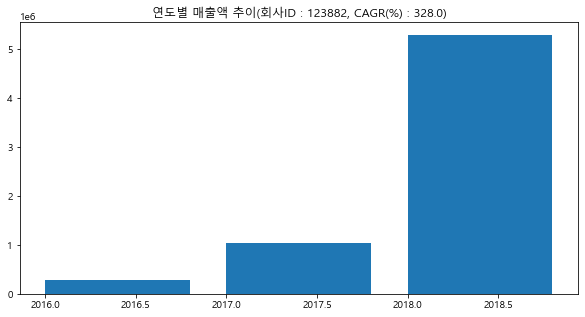

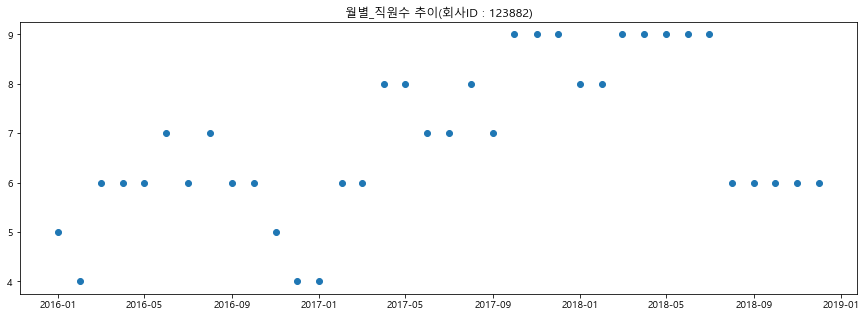

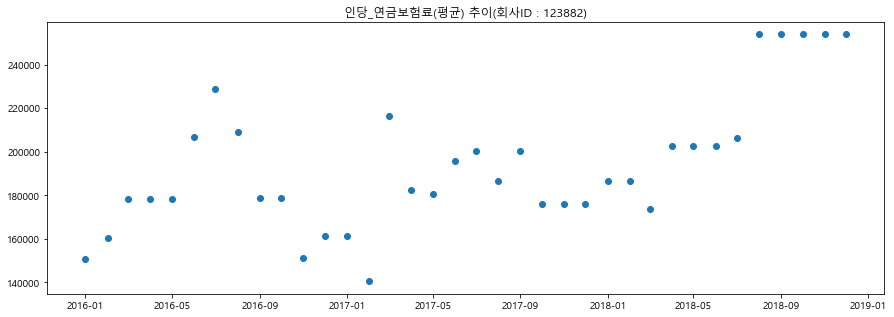

< 127366 >


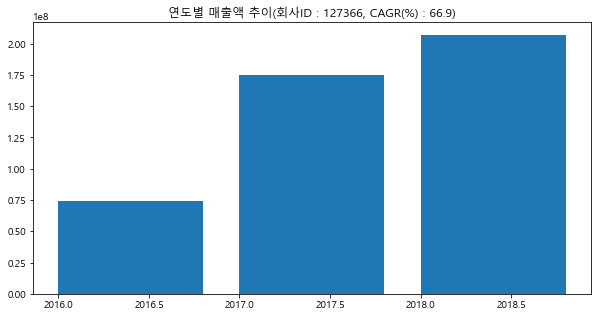

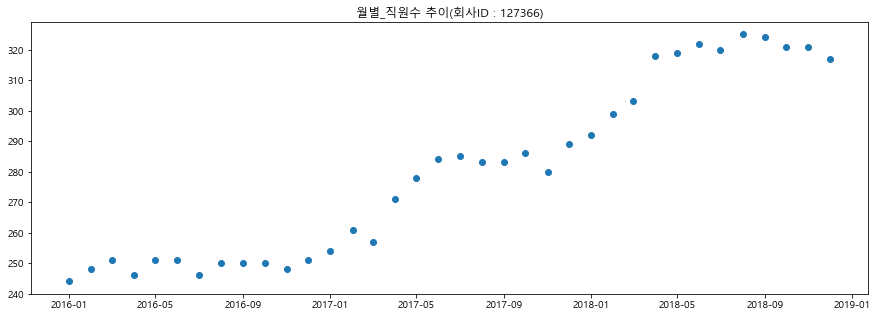

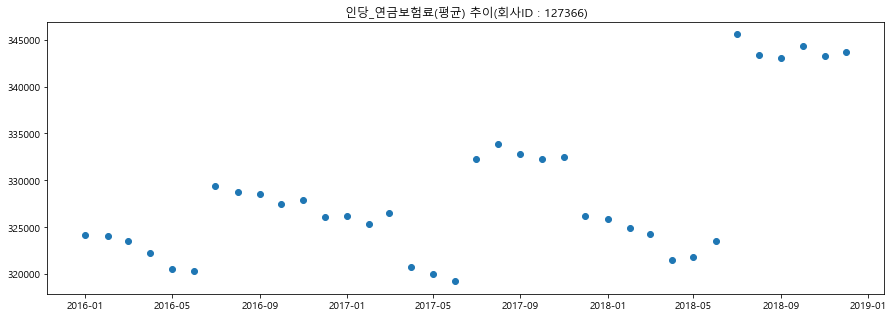

< 132156 >


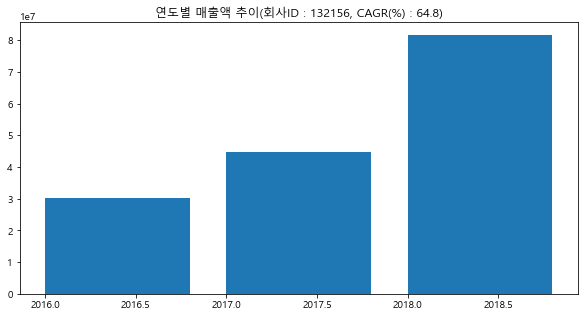

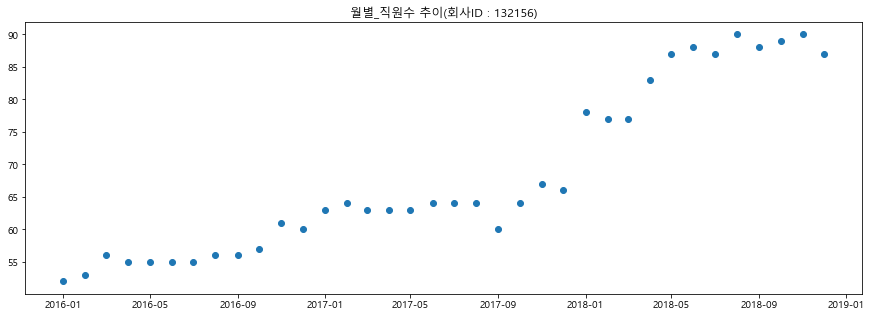

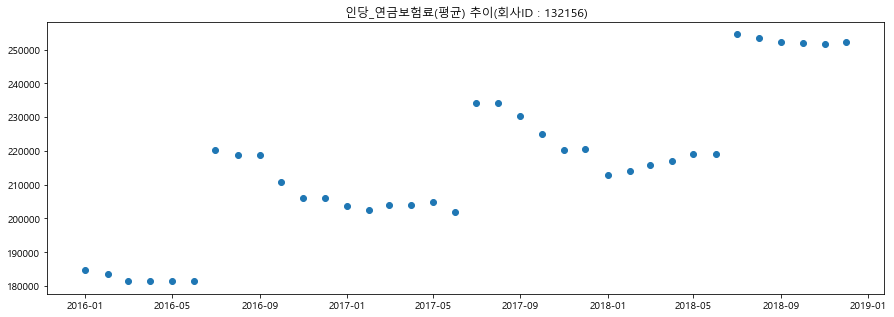

< 163400 >


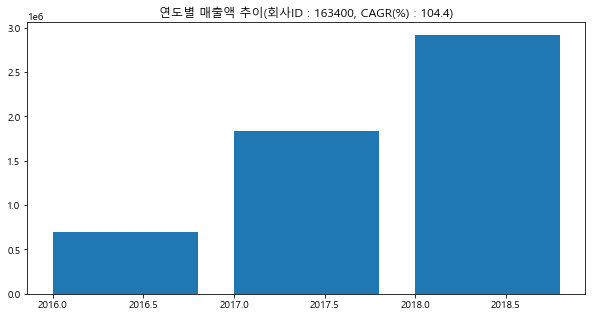

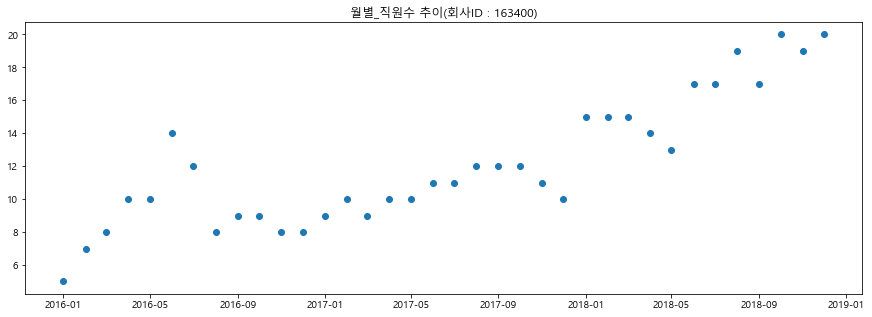

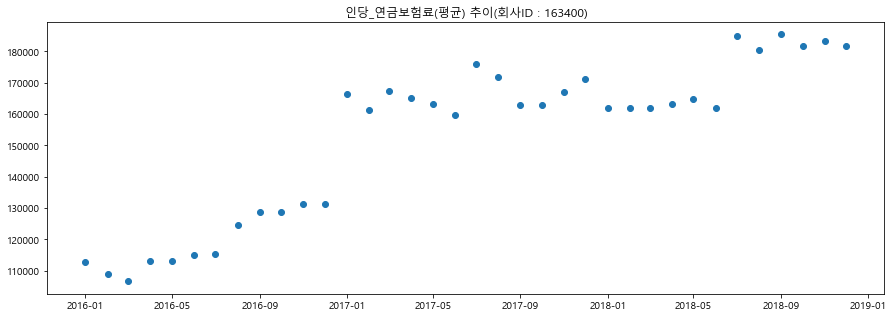

< 232218 >


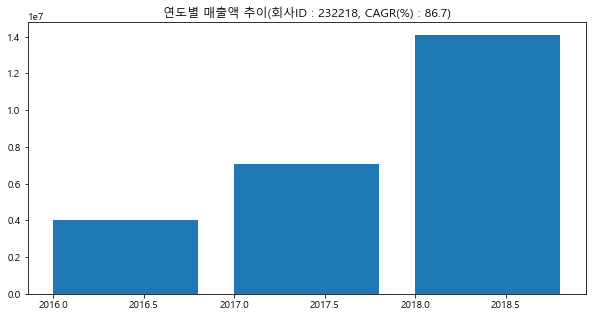

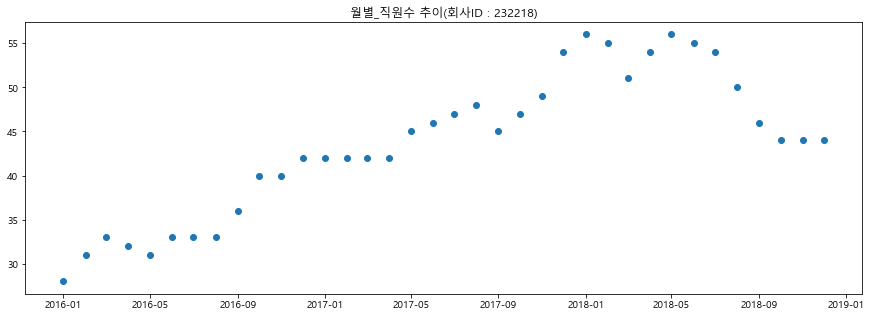

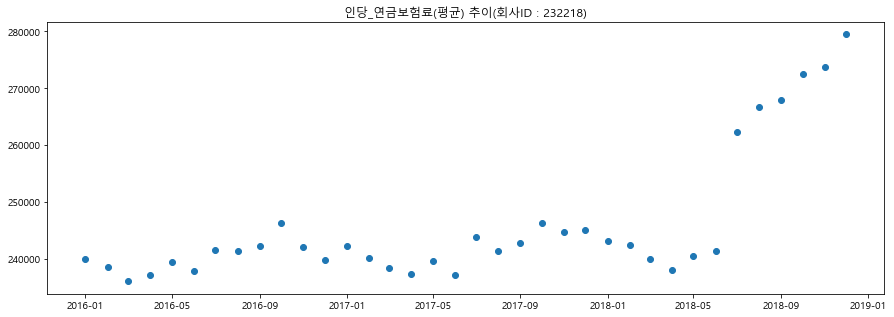

< 297175 >


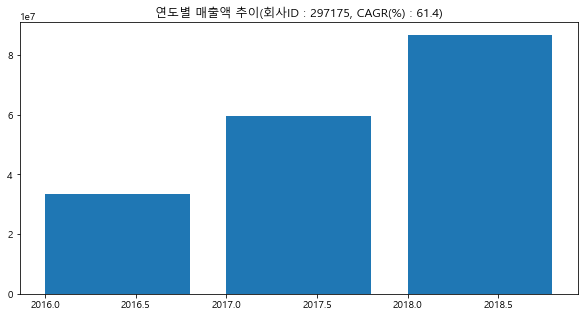

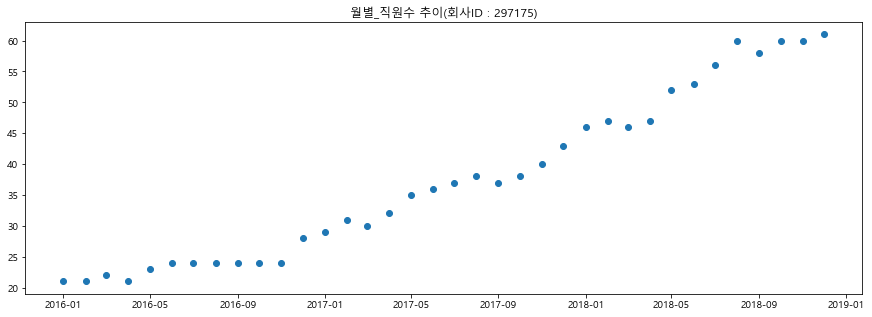

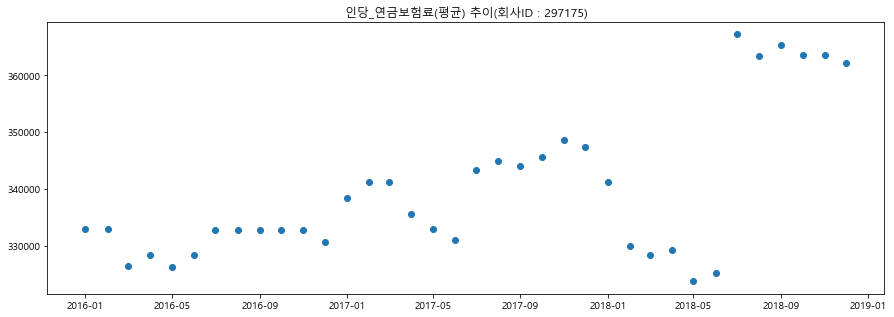

< 470994 >


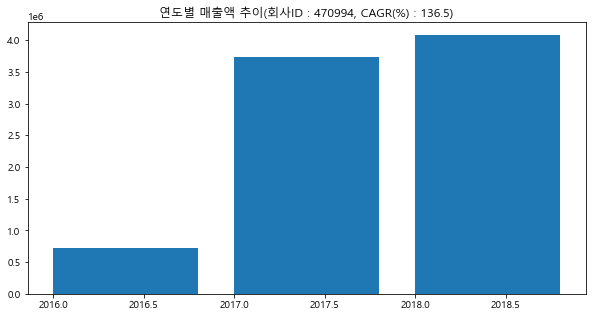

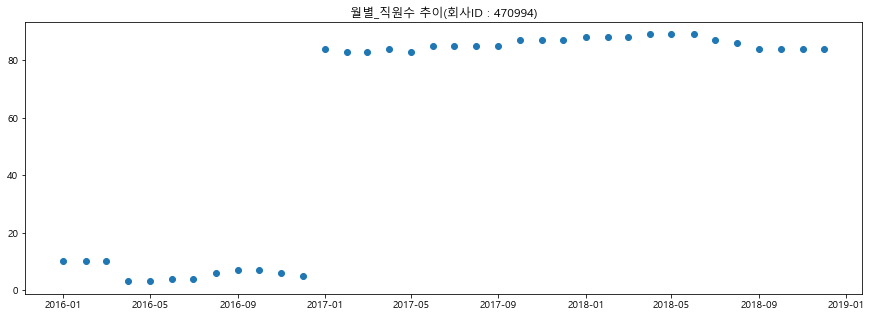

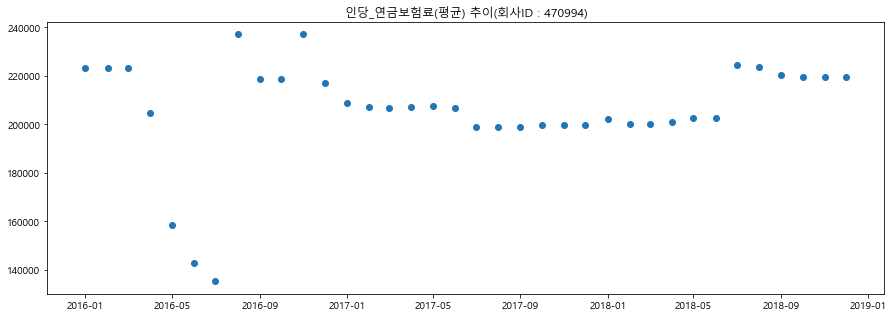

In [223]:
for id_v in finalist:
    print("="*100)
    print(f"< {id_v} >")
    show_all(id_v)